huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Caricamento dati dal CSV: /kaggle/input/datasetdescriptionimgconcise/image_analysis_qwen_2x2_with_metadata_max_tokens_512_concise.csv

Generati 100 prompt per le immagini.

Caricamento modello Qwen/Qwen3-4B...


/tmp/ipykernel_35/3542454111.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Image Name'] = df['Image Name'].replace('', pd.NA).fillna(method='ffill')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Modello caricato con successo.

Inizio generazione risposte dal modello (temperatura alta, con sampling)...

=== Elaborazione immagine 1/100: aleksey-savrasov_courtyard-spring-1853.jpg ===

Risposta generata dal modello:

RGB: (100, 180, 50) (140, 160, 60) (120, 150, 70) (130, 170, 65) (110, 165, 55)

=== Elaborazione immagine 2/100: alfred-sisley_village-on-the-banks-of-the-seine-1872.jpg ===

Risposta generata dal modello:

RGB: (100, 180, 120) (120, 160, 100) (140, 150, 90) (130, 170, 80) (110, 160, 100)

=== Elaborazione immagine 3/100: chaldin-alex_lilies.jpg ===

Risposta generata dal modello:

RGB: (230, 180, 100) (210, 160, 80) (200, 150, 70) (190, 140, 60) (180, 130, 50)

=== Elaborazione immagine 4/100: currier-and-ives_catching-a-trout-1854.jpg ===

Risposta generata dal modello:

RGB: (120, 160, 100) (140, 150, 90) (130, 140, 80) (150, 145, 95) (125, 155, 85)

=== Elaborazione immagine 5/100: edvard-munch_girl-yawning-1913.jpg ===

Risposta generata dal modello:

RGB: (18

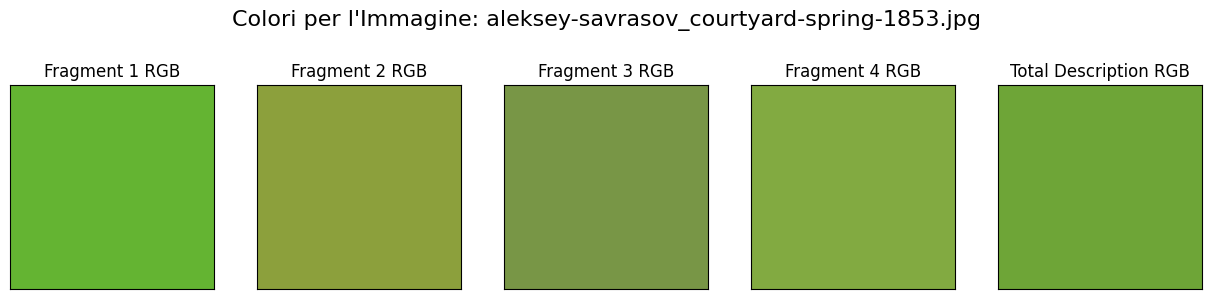

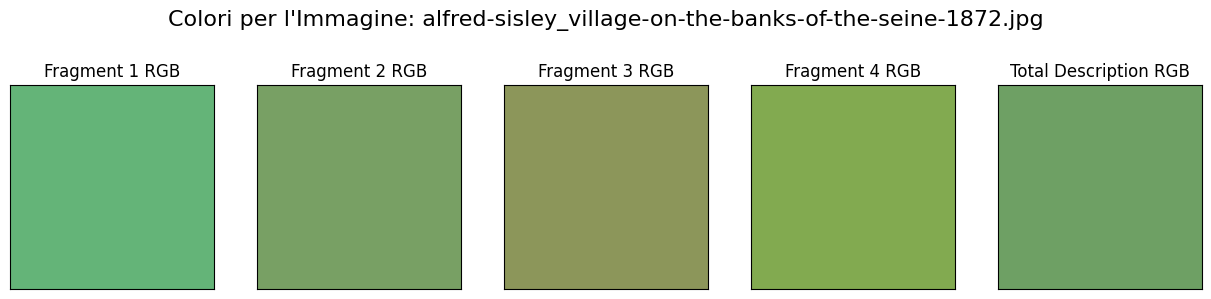

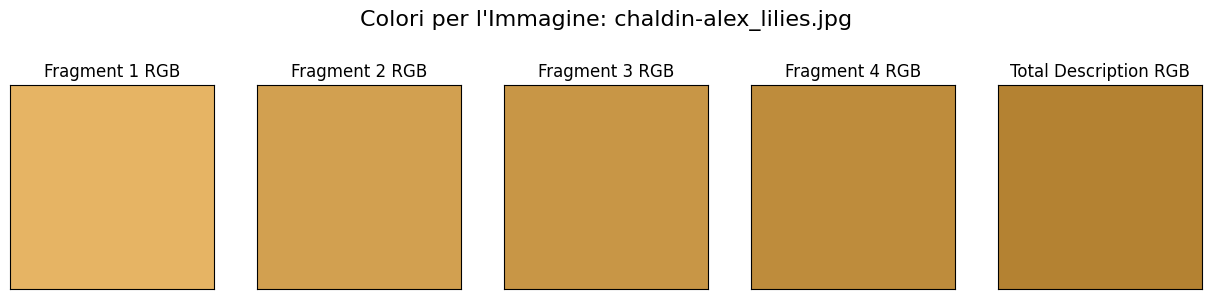

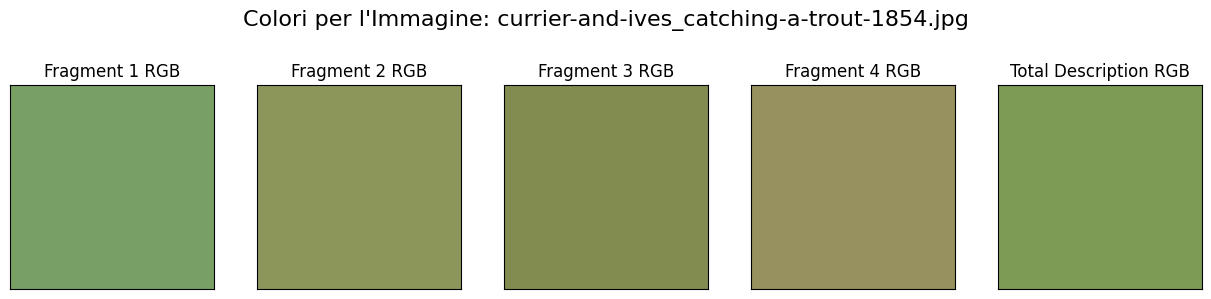

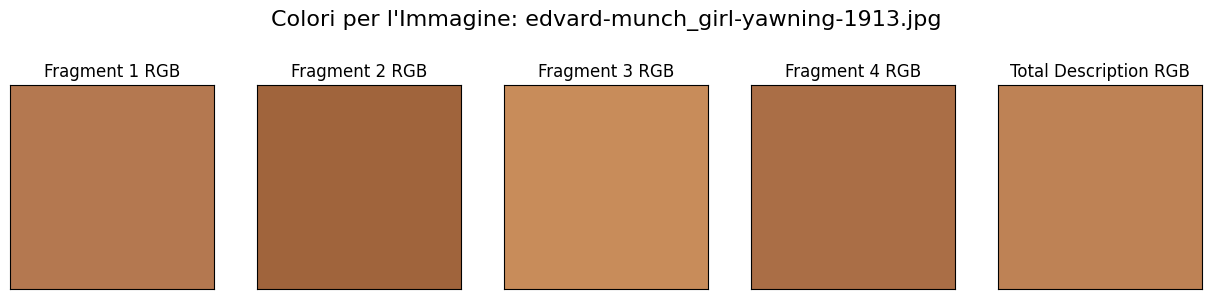


Visualizzazione completata. Modifica il parametro 'max_immagini' per vederne di più.


In [6]:
# Installazione pacchetti (da eseguire solo la prima volta)
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q qwen-omni-utils -U
!pip install -q bitsandbytes -U
!pip install -q accelerate
!pip install -q pandas
!pip install -q matplotlib # Aggiunto per la visualizzazione finale

# Import
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import re
import gc
import csv
import pandas as pd
import matplotlib.pyplot as plt
import sys # Importa sys per sys.exit
import traceback # Importa traceback per stampare errori completi

model_name = "Qwen/Qwen3-4B"

# --- Preparazione della lista dei prompt dal CSV ---
# Percorso del file CSV di input con le descrizioni delle IMMAGINI
csv_file = "/kaggle/input/datasetdescriptionimgconcise/image_analysis_qwen_2x2_with_metadata_max_tokens_512_concise.csv" # <--- AGGIORNATO QUI per il tuo CSV delle immagini

prompt_list = []
results_for_csv = []

print(f"Caricamento dati dal CSV: {csv_file}")
try:
    # Leggiamo il CSV con pandas, assumendo che abbia un header come "Image Name", "Description Type", "Description"
    # 'keep_default_na=False' previene che le stringhe vuote vengano interpretate come NaN
    df = pd.read_csv(csv_file, keep_default_na=False)
    
    # Riempi i valori NaN/vuoti nella colonna 'Image Name' con il valore precedente
    df['Image Name'] = df['Image Name'].replace('', pd.NA).fillna(method='ffill')

    # Raggruppa i dati per Nome Immagine (prima 'Nome Canzone')
    for image_name, group in df.groupby('Image Name'): # <--- Cambiato da song_name a image_name
        descriptions = {}
        for _, row in group.iterrows():
            desc_type = str(row['Description Type']).strip()
            desc_text = str(row['Description']).strip()
            descriptions[desc_type] = desc_text

        # Costruisci l'elenco delle descrizioni nell'ordine desiderato (Fragment 1-4, poi Total)
        NUM_DESCRIPTIONS_EXPECTED = 5 # 4 frammenti + 1 descrizione totale
        ordered_descriptions_content = []
        
        # Nomi delle colonne nel tuo CSV delle immagini sono "Fragment X" e "Total"
        for i in range(1, 5): # Fragment 1 a 4
            content = descriptions.get(f'Fragment {i}', '') # <--- Nomi colonne CSV: "Fragment X"
            if content:
                ordered_descriptions_content.append({'label': f'Fragment {i}', 'content': content})

        # Aggiungi la descrizione totale per ultima
        overall_content = descriptions.get('Total', '') # <--- Nomi colonne CSV: "Total"
        if overall_content:
            ordered_descriptions_content.append({'label': 'Total', 'content': overall_content}) # <--- Cambiato label a 'Total'

        # Assicurati di avere esattamente 5 descrizioni
        while len(ordered_descriptions_content) < NUM_DESCRIPTIONS_EXPECTED:
            # Assegna un label che indichi il frammento mancante
            if len(ordered_descriptions_content) < 4:
                missing_label = f"Fragment {len(ordered_descriptions_content) + 1} (Missing)"
            else:
                missing_label = "Total (Missing)"
            ordered_descriptions_content.append({'label': missing_label, 'content': ''})

        # Costruisci il prompt per il modello
        prompt = f"Image Name: {image_name}\n\n" # <--- Cambiato da song_name a image_name
        prompt += "Dati questi frammenti descrittivi di un'immagine, valuta su una scala da 0 a 255 quanto ciascuno dei seguenti stati emotivi è evocato dalla descrizione:\n" # <--- Cambiato da 'canzone' a 'immagine'
        prompt += "agitazione/movimento (R), calma (G), tristezza (B).\n\n"
        prompt += f"Restituisci **ESATTAMENTE {NUM_DESCRIPTIONS_EXPECTED} triple RGB COMPLETE**, una dopo l'altra, su una SINGOLA riga. \n"
        prompt += "Non includere nessuna spiegazione, numerazione, elenchi puntati o altro testo aggiuntivo. Non usare la modalità di pensiero ('thinking mode').\n"
        prompt += f"Inizia la riga con 'RGB:' e poi le {NUM_DESCRIPTIONS_EXPECTED} triple. Ogni tripla deve contenere esattamente tre valori separati da virgole.\n\n"
        prompt += "Ecco l'ESEMPIO ESATTO del formato desiderato (solo 5 triple complete, su una riga):\n"
        prompt += "RGB: (R1, G1, B1) (R2, G2, B2) (R3, G3, B3) (R4, G4, B4) (R5, G5, B5)\n\n"
        prompt += "Ecco i frammenti:\n"
        for item in ordered_descriptions_content:
            if item['content']:
                prompt += f"- {item['label']}: {item['content']}\n"
        
        prompt_list.append({'image_name': image_name, 'prompt_text': prompt}) # <--- Cambiato da song_name a image_name

    print(f"\nGenerati {len(prompt_list)} prompt per le immagini.")

except FileNotFoundError:
    print(f"Errore: Il file CSV '{csv_file}' non è stato trovato.")
    print("Assicurati che il file si trovi nel percorso specificato.")
    sys.exit(1)
except Exception as e:
    print(f"Si è verificato un errore durante la lettura del CSV: {e}")
    print("Assicurati che il CSV abbia le colonne 'Image Name', 'Description Type', 'Description'.") # <--- Aggiornato messaggio di errore
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)

# --- Fine preparazione della lista dei prompt ---


# Parametri modello
compute_dtype = torch.float16

# Configurazione quantizzazione 4-bit
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=compute_dtype
)

print(f"\nCaricamento modello {model_name}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        quantization_config=quant_config,
        device_map="auto",
        low_cpu_mem_usage=True,
        torch_dtype=compute_dtype
    )
    print("✅ Modello caricato con successo.")
except Exception as e:
    print(f"❌ Errore durante il caricamento del modello: {e}")
    traceback.print_exc(file=sys.stdout)
    sys.exit(1)


# Loop sui prompt
print("\nInizio generazione risposte dal modello (temperatura alta, con sampling)...") # <--- Testo informativo
for idx, entry in enumerate(prompt_list, start=1):
    image_name = entry['image_name'] # <--- Cambiato da song_name a image_name
    prompt_text = entry['prompt_text']

    print(f"\n=== Elaborazione immagine {idx}/{len(prompt_list)}: {image_name} ===\n") # <--- Cambiato da canzone a immagine

    chat = [{"role": "user", "content": prompt_text}]
    chat_text = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True, enable_thinking=False)

    inputs = tokenizer(chat_text, return_tensors="pt", truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,    # <--- do_sample RIMANE TRUE come da tuo ultimo codice
        temperature=0.1,   # <--- temperature RIMANE 0.7 come da tuo ultimo codice
        num_return_sequences=1,
    )

    response_text = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()
    print("Risposta generata dal modello:\n")
    print(response_text)

    # --- MODIFICA REGEX E GESTIONE RGB ---
    # La regex e la logica di parsing rimangono le stesse, cercheranno le triple RGB
    # indipendentemente dal prefisso "RGB:" se il modello non lo produce.
    rgb_value_pattern = re.compile(r"\((\d{1,3}),\s*(\d{1,3}),\s*(\d{1,3})\)")
    found_rgb_matches = rgb_value_pattern.findall(response_text)

    current_image_rgb_values = [image_name] # <--- Cambiato da current_song_rgb_values a current_image_rgb_values

    # Popola fino a 5 valori RGB (4 frammenti + Totale).
    NUM_EXPECTED_RGB = 5
    for i in range(NUM_EXPECTED_RGB):
        if i < len(found_rgb_matches):
            try:
                r, g, b = int(found_rgb_matches[i][0]), int(found_rgb_matches[i][1]), int(found_rgb_matches[i][2])
                r, g, b = max(0, min(255, r)), max(0, min(255, g)), max(0, min(255, b))
                current_image_rgb_values.append(f"rgb({r}, {g}, {b})")
            except ValueError:
                print(f"Errore nel parsing RGB per il match {found_rgb_matches[i] if i < len(found_rgb_matches) else 'inatteso'}. Usando rgb(0, 0, 0).")
                current_image_rgb_values.append("rgb(0, 0, 0)")
        else:
            current_image_rgb_values.append("rgb(0, 0, 0)")
            print(f"Avviso: Meno di {NUM_EXPECTED_RGB} triple RGB complete trovate per {image_name}. Aggiungendo rgb(0, 0, 0) per il frammento/descrizione {i+1}.") # <--- Cambiato da song_name a image_name

    results_for_csv.append(current_image_rgb_values) # <--- Cambiato da current_song_rgb_values a current_image_rgb_values

    # Pulisci la memoria GPU e CPU dopo ogni elaborazione
    del inputs, outputs
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

# --- Salvataggio finale dei dati ---

print("\n--- Salvataggio dei colori RGB in CSV ---")
output_csv_file = "valutazione_rgb_immagini.csv" # <--- Nome file di output aggiornato
# L'header ora riflette 4 frammenti + Descrizione Totale per le IMMAGINI
csv_header = ['Image Name', 'Fragment 1 RGB', 'Fragment 2 RGB', 'Fragment 3 RGB', 'Fragment 4 RGB', 'Total Description RGB'] # <--- Header aggiornato

try:
    with open(output_csv_file, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(csv_header)
        writer.writerows(results_for_csv)
    print(f"✅ Colori RGB salvati con successo in '{output_csv_file}'")
except Exception as e:
    print(f"❌ Errore durante il salvataggio del file CSV: {e}")
    traceback.print_exc(file=sys.stdout)


print("\nProcessing complete. I valori RGB sono stati salvati nel file CSV.")


# --- Parte di visualizzazione (con matplotlib) ---
def parse_rgb_to_normalized_tuple(rgb_string):
    """
    Converte una stringa come "rgb(r, g, b)" in una tupla di float (r, g, b)
    normalizzati nell'intervallo [0, 1] per matplotlib.
    """
    try:
        numeri = re.findall(r'\d+', rgb_string)
        if len(numeri) == 3:
            r = int(numeri[0]) / 255.0
            g = int(numeri[1]) / 255.0
            b = int(numeri[2]) / 255.0
            return (r, g, b)
        else:
            return (0.0, 0.0, 0.0)
    except (ValueError, IndexError):
        return (0.0, 0.0, 0.0)

def visualizza_colori_immagini(nome_file_csv, max_immagini=5): # <--- Cambiato nome funzione e parametro
    """
    Legge un file CSV e visualizza i colori per ogni immagine usando matplotlib.
    Mostra una finestra per ogni immagine, una alla volta.
    Args:
        nome_file_csv (str): Il nome del file CSV da leggere.
        max_immagini (int): Il numero massimo di immagini da visualizzare.
    """
    try:
        with open(nome_file_csv, mode='r', newline='', encoding='utf-8') as file:
            lettore_csv = csv.reader(file)
            header = next(lettore_csv) # Salta l'intestazione

            print(f"\nSto per visualizzare i colori delle prime {max_immagini} immagini dal file CSV generato.") # <--- Aggiornato testo
            print("Chiudi ogni finestra per procedere alla successiva.")

            immagini_visualizzate = 0 # <--- Cambiato contatore
            for riga in lettore_csv:
                if not riga:
                    continue

                if immagini_visualizzate >= max_immagini: # <--- Cambiato condizione
                    print(f"\nVisualizzazione completata. Modifica il parametro 'max_immagini' per vederne di più.") # <--- Aggiornato testo
                    break

                nome_immagine = riga[0] # <--- Cambiato da nome_canzone a nome_immagine
                # Ora prendiamo 5 stringhe di colore: 4 frammenti + Totale
                colori_stringa = riga[1:6] # Indici da 1 a 5 per 5 colonne

                colori = [parse_rgb_to_normalized_tuple(s) for s in colori_stringa]
                
                # Crea la figura e i subplot (1 riga, 5 colonne)
                fig, axes = plt.subplots(1, 5, figsize=(12.5, 3)) # 5 colonne per 5 colori
                fig.suptitle(f"Colori per l'Immagine: {nome_immagine}", fontsize=16) # <--- Aggiornato titolo

                # Definisce i titoli per ogni riquadro (4 frammenti + Totale)
                titoli = ['Fragment 1 RGB', 'Fragment 2 RGB', 'Fragment 3 RGB', 'Fragment 4 RGB', 'Total Description RGB'] # <--- Aggiornato titoli per matchare l'header del CSV di output

                for ax, colore, titolo in zip(axes, colori, titoli):
                    ax.imshow([[colore]])
                    ax.set_title(titolo)
                    ax.set_xticks([])
                    ax.set_yticks([])

                plt.tight_layout(rect=[0, 0, 1, 0.9])
                plt.show()

                immagini_visualizzate += 1 # <--- Cambiato contatore

    except FileNotFoundError:
        print(f"ERRORE: Il file '{nome_file_csv}' non è stato trovato.")
        print("Assicurati che il file si trovi nel percorso specificato.")
    except ImportError:
        print("ERRORE: La libreria 'matplotlib' non è installata.")
        print("Per favorire, installala eseguendo il comando: pip install matplotlib")
    except Exception as e:
        print(f"Si è verificato un errore imprevisto durante la visualizzazione: {e}")
        traceback.print_exc(file=sys.stdout)

# --- ESECUZIONE DELLA VISUALIZZAZIONE ---
file_da_leggere_visualizzazione = output_csv_file # Usa il nome del file CSV appena salvato
visualizza_colori_immagini(file_da_leggere_visualizzazione, max_immagini=5) # Puoi cambiare max_immagini


Sto per visualizzare i colori delle prime 100 immagini dal file CSV generato.
Chiudi ogni finestra per procedere alla successiva.


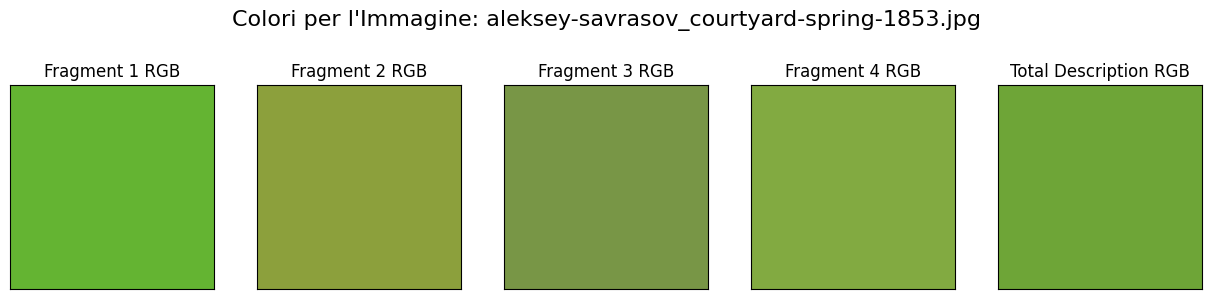

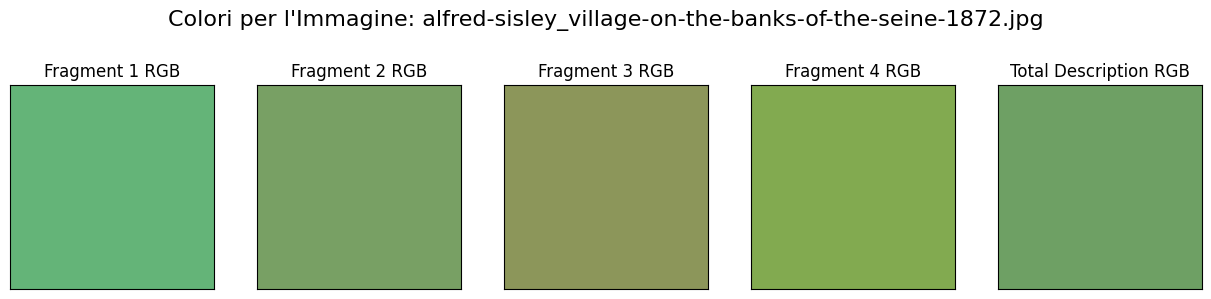

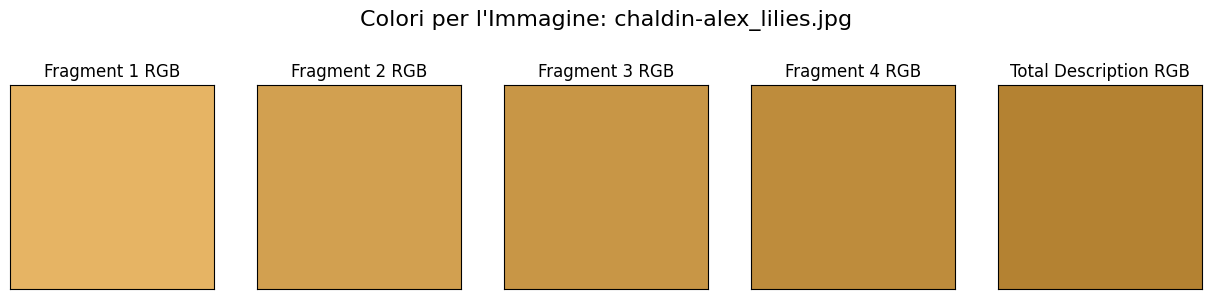

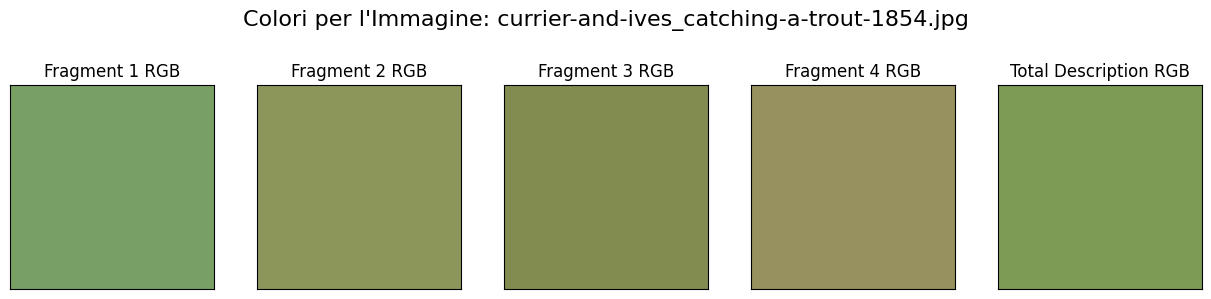

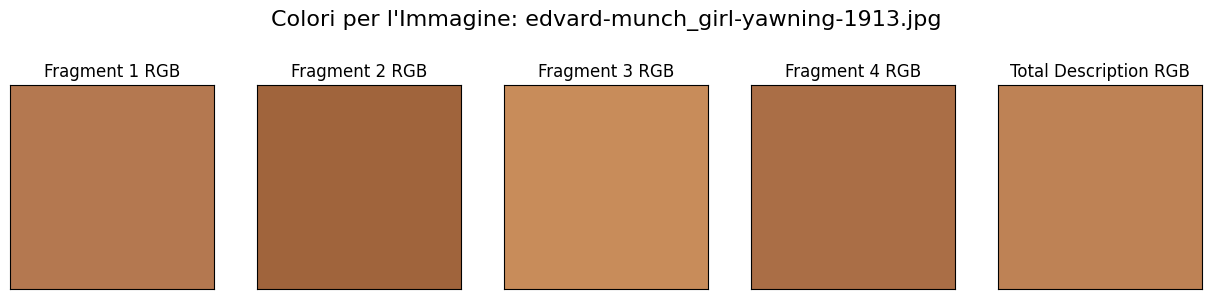

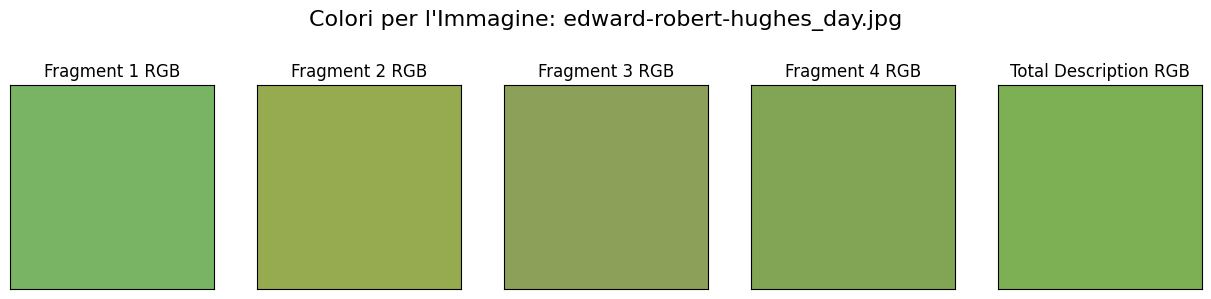

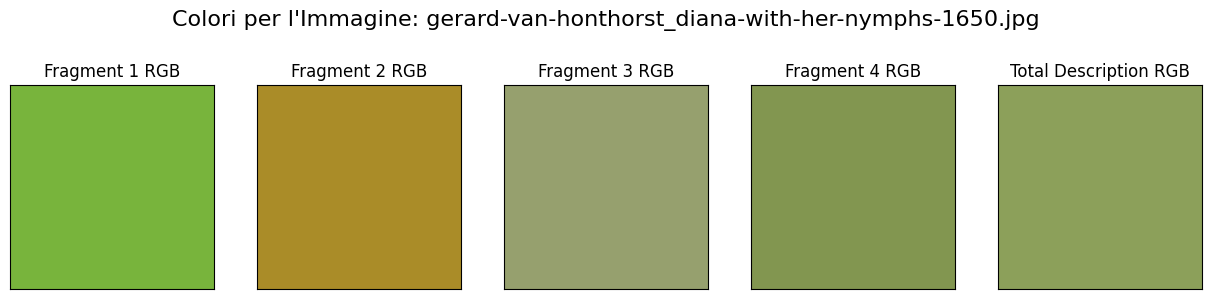

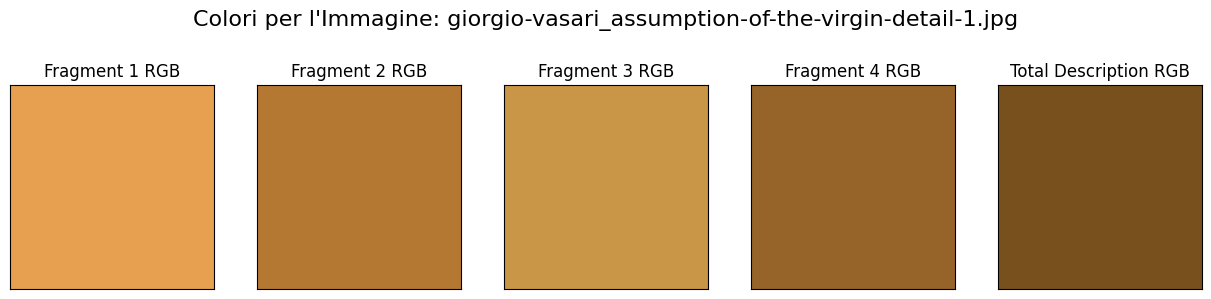

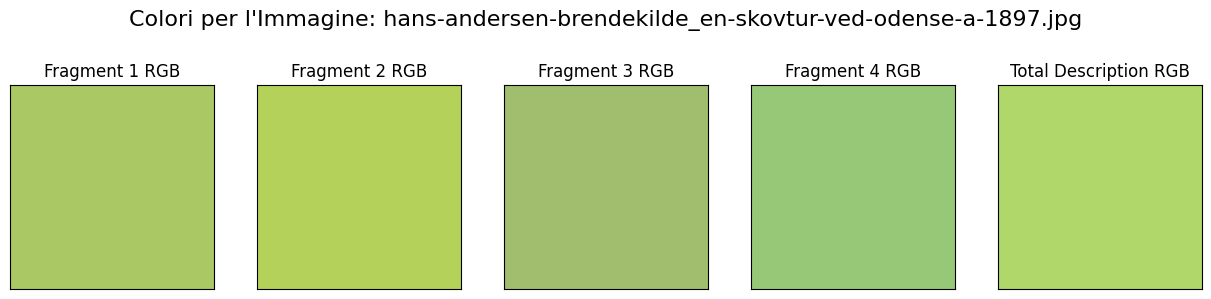

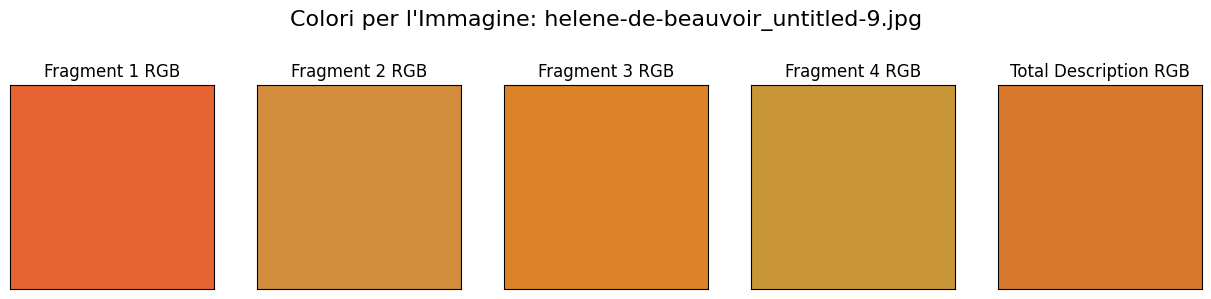

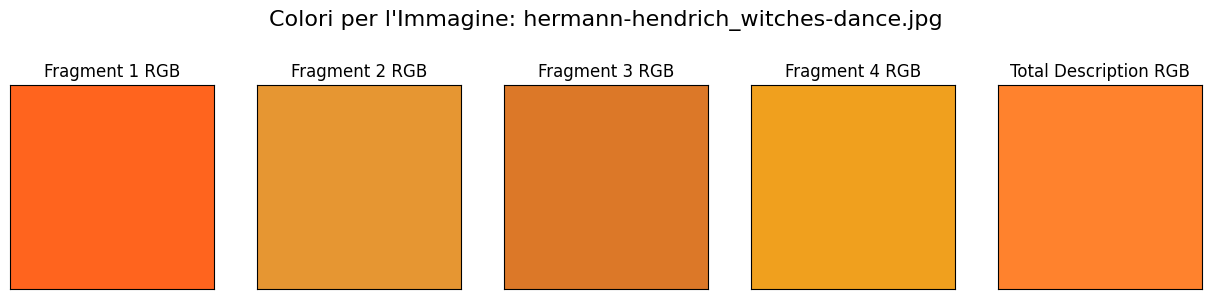

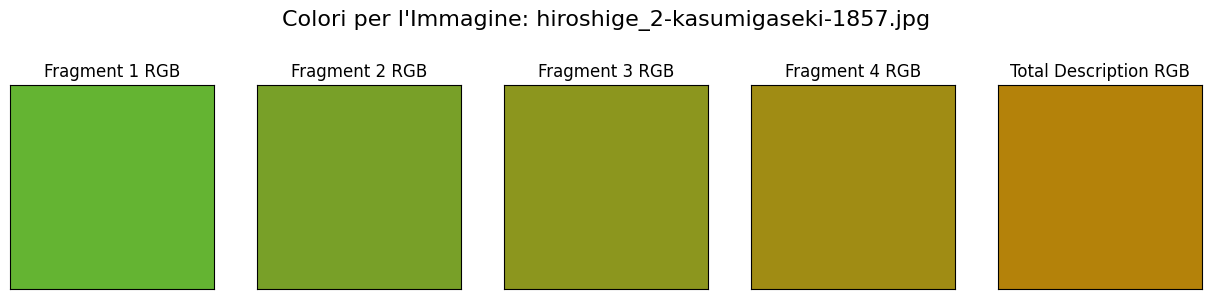

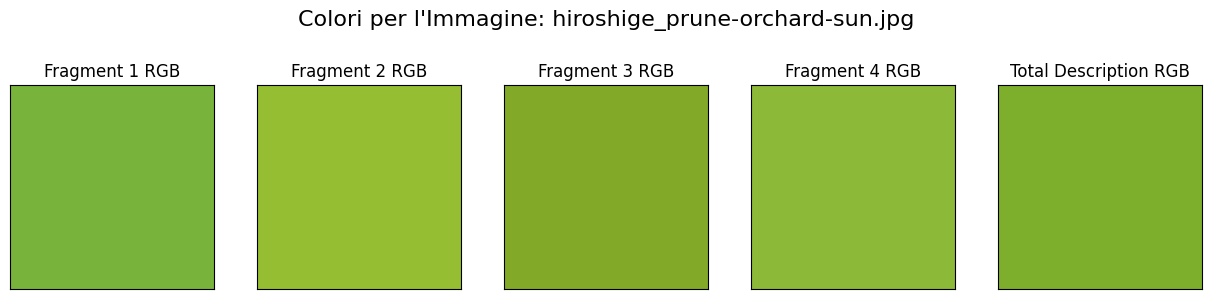

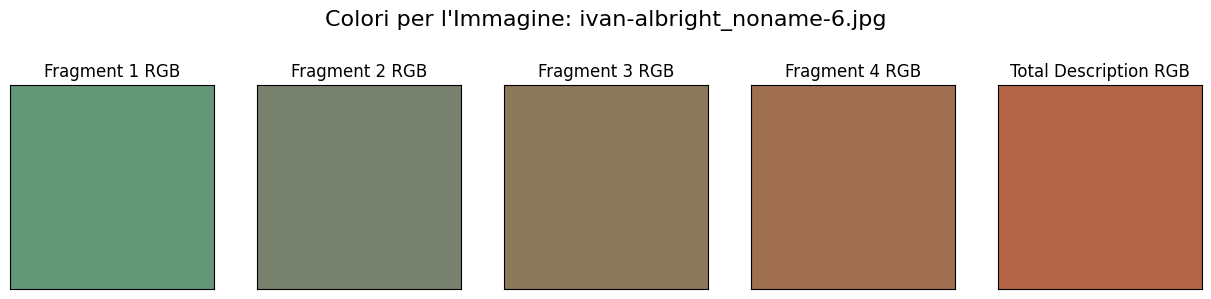

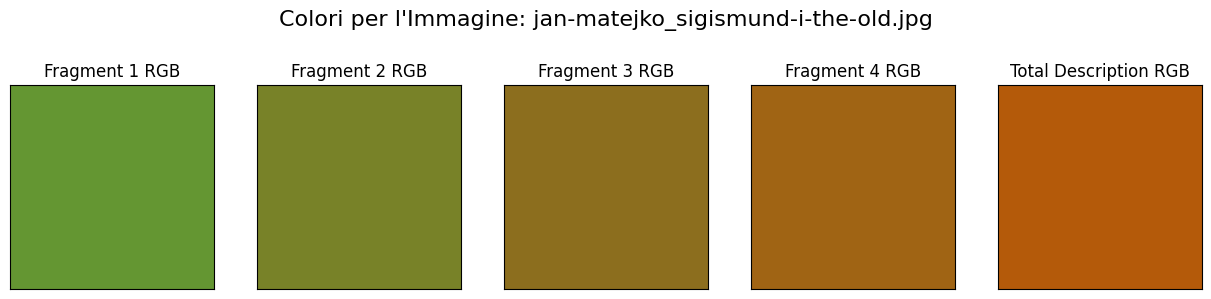

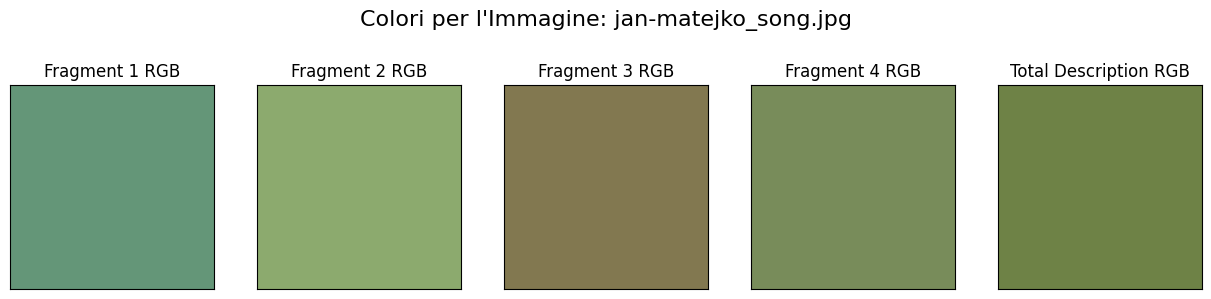

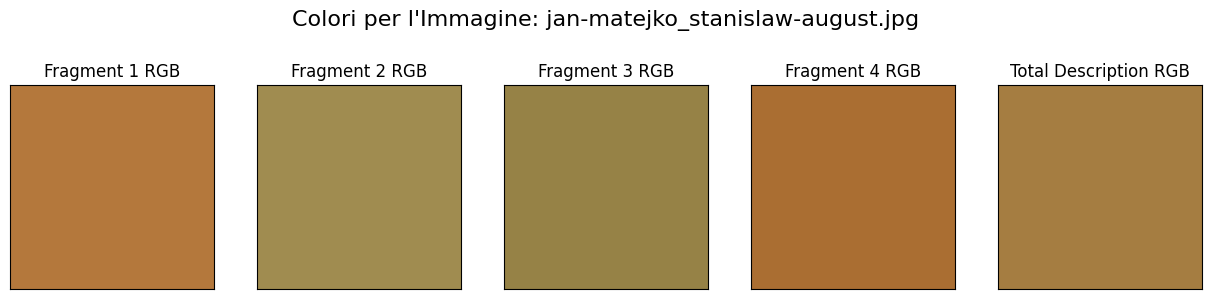

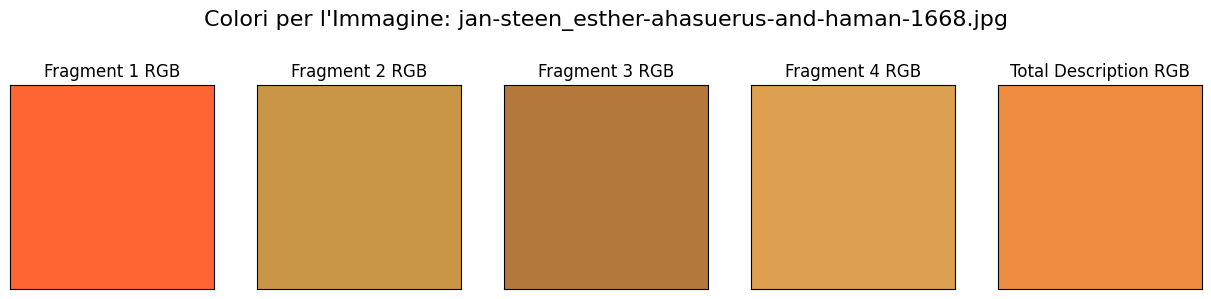

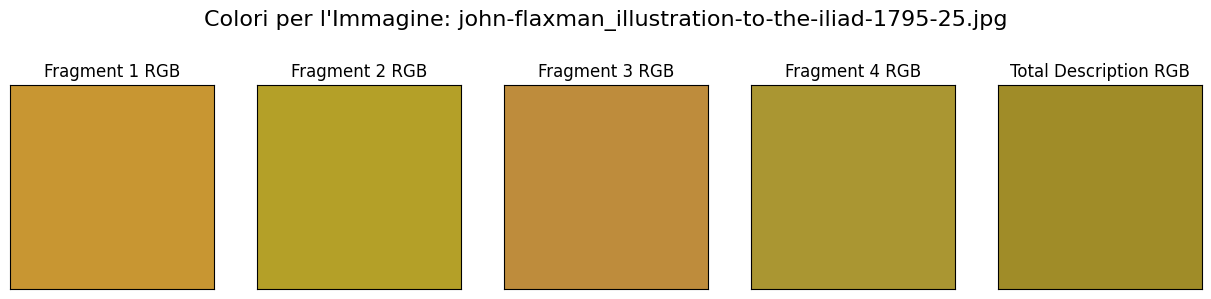

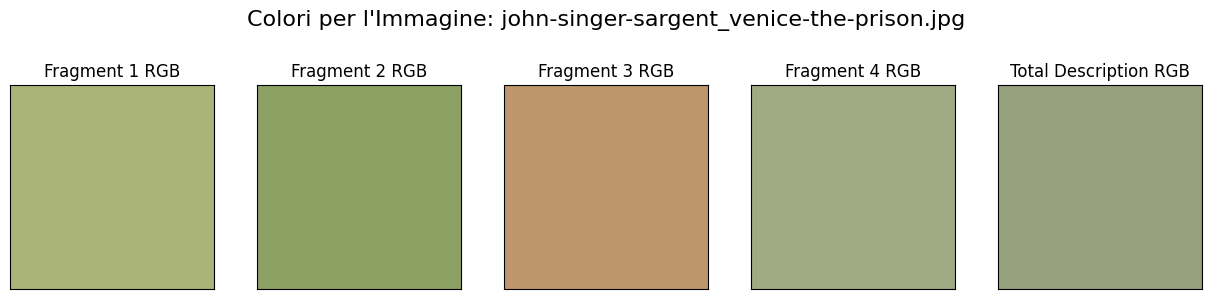

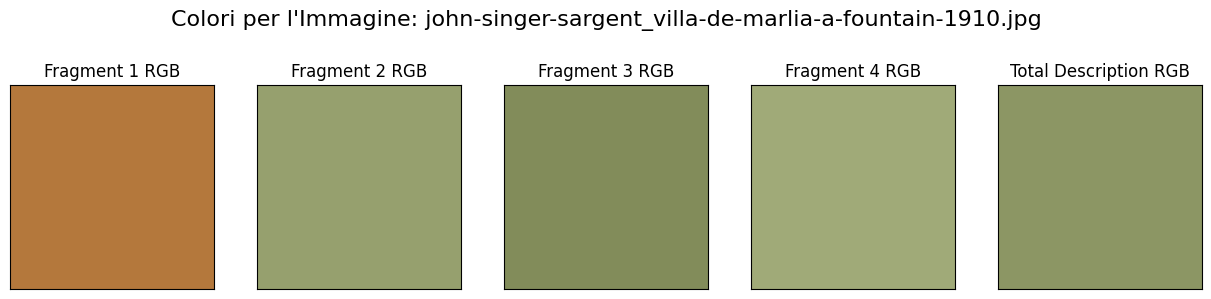

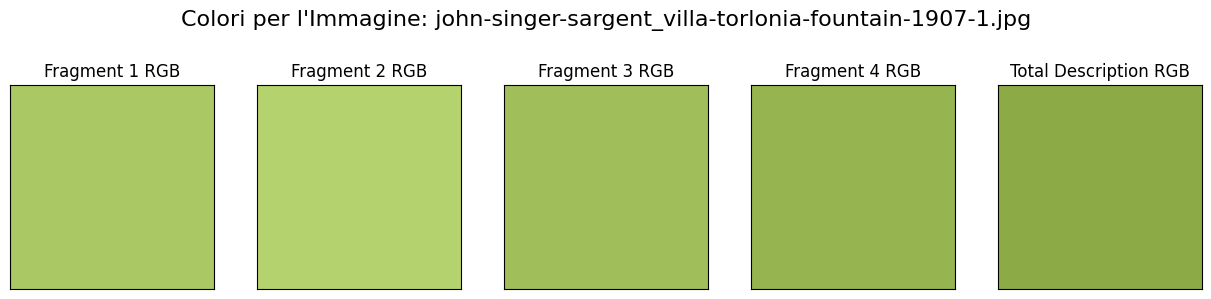

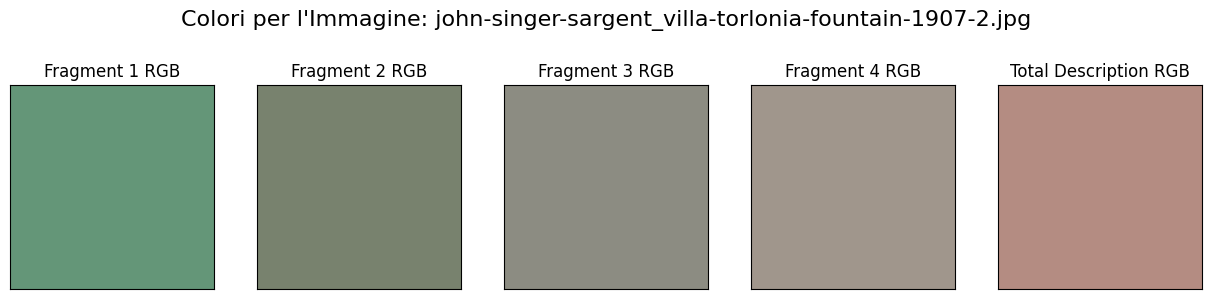

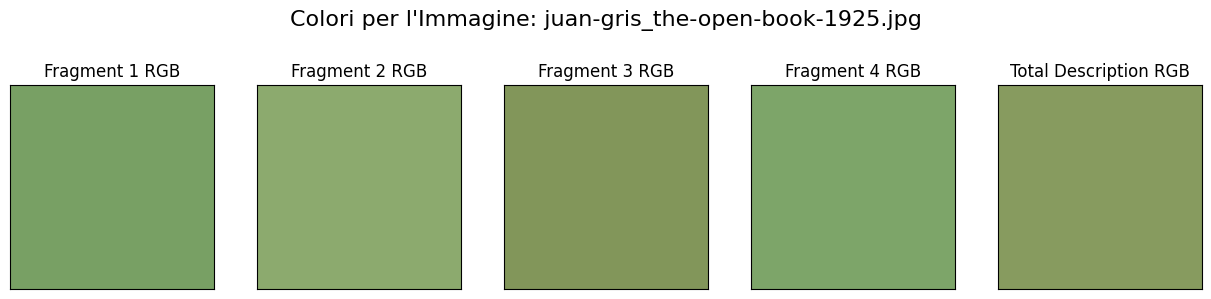

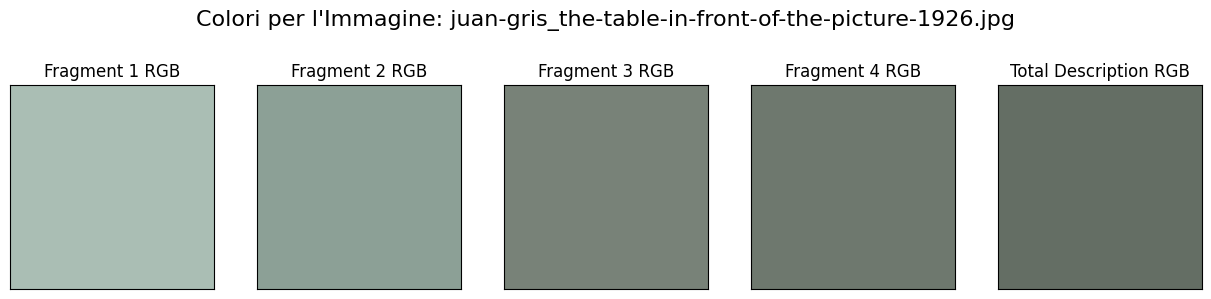

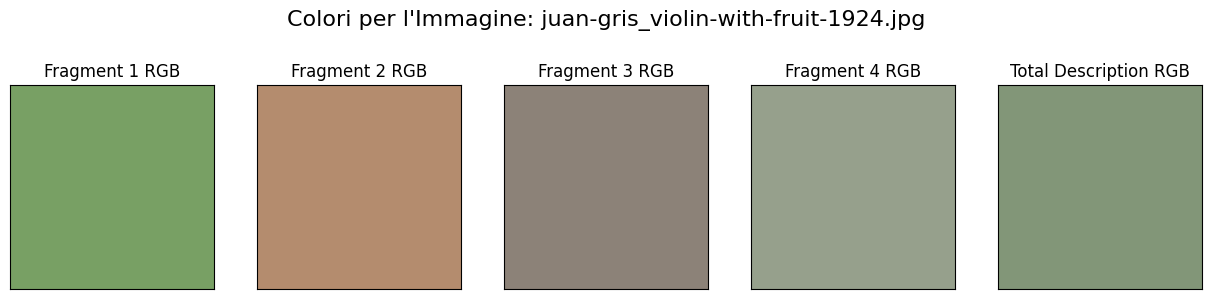

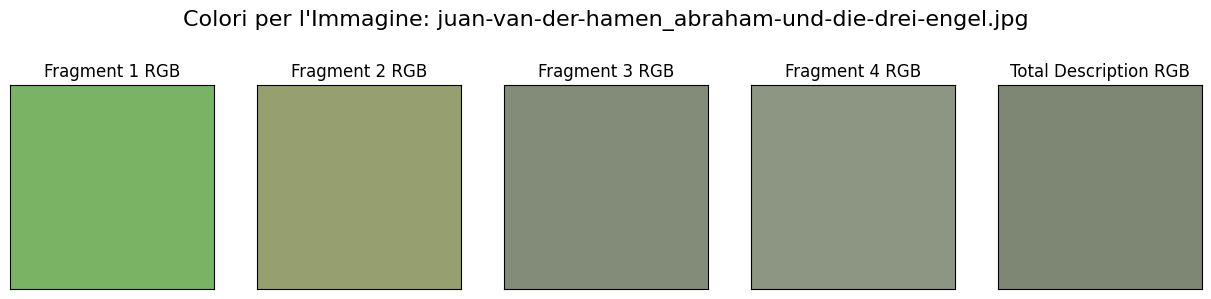

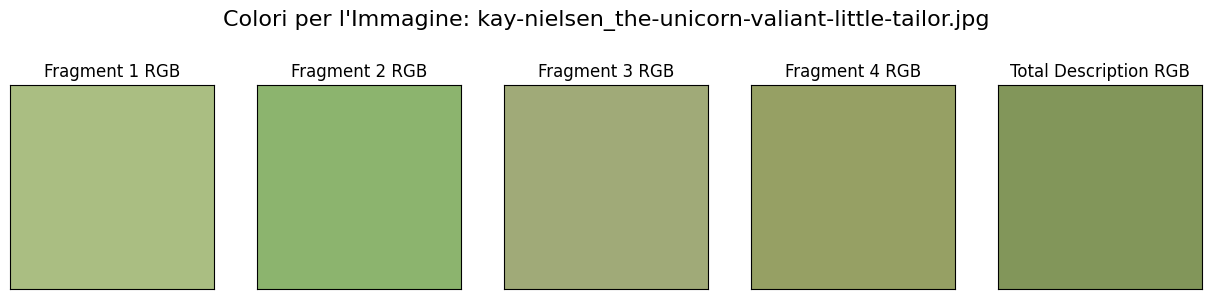

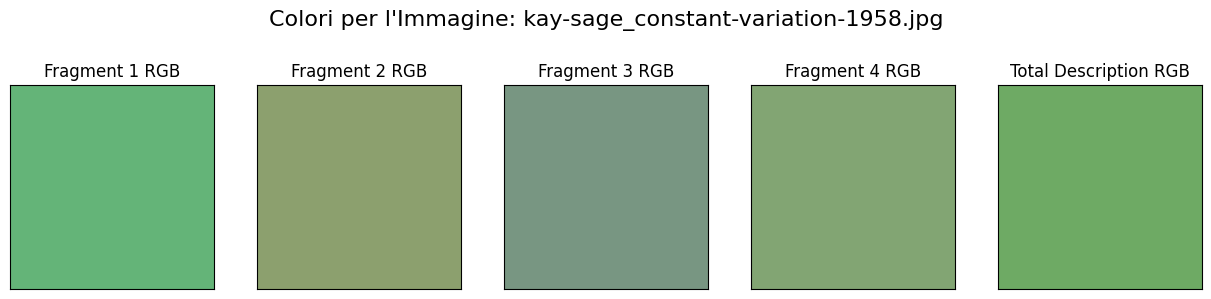

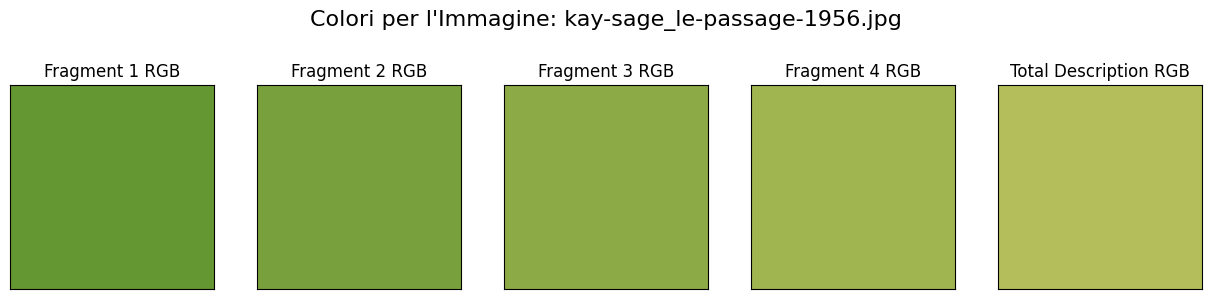

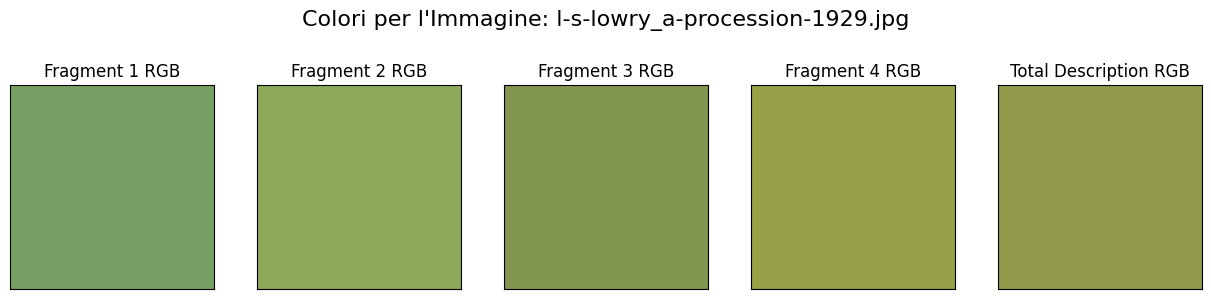

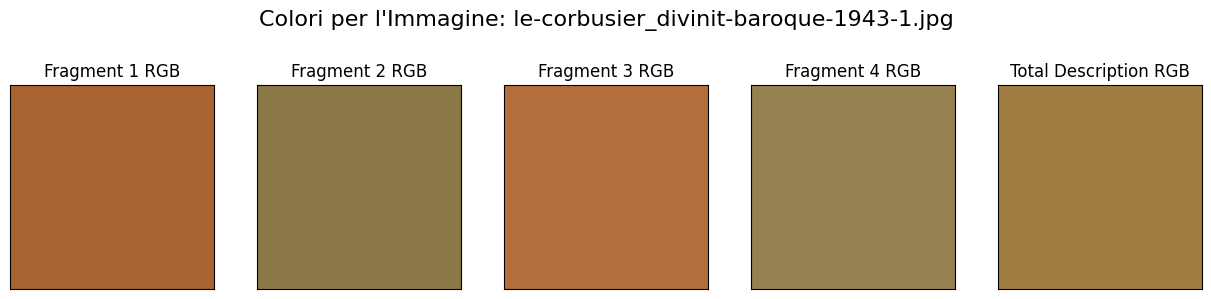

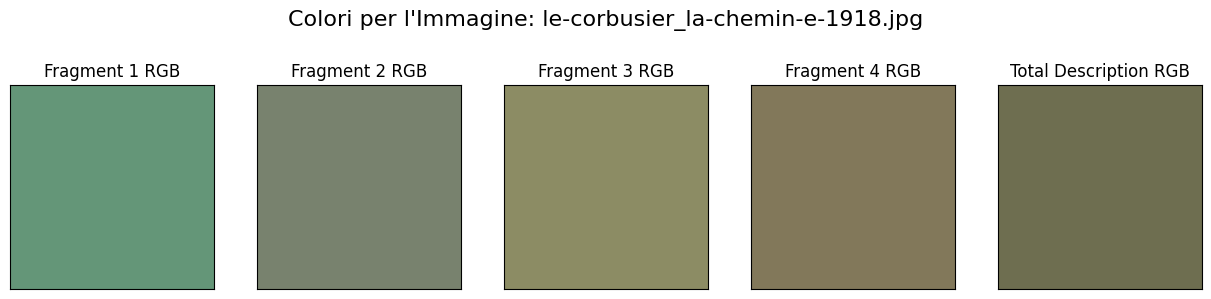

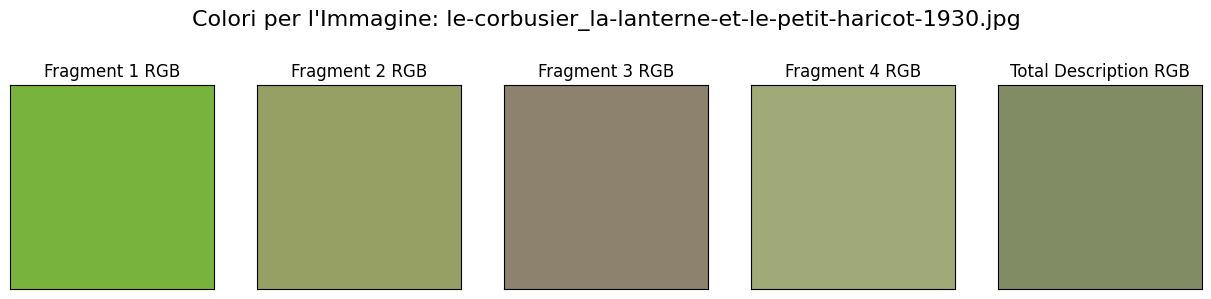

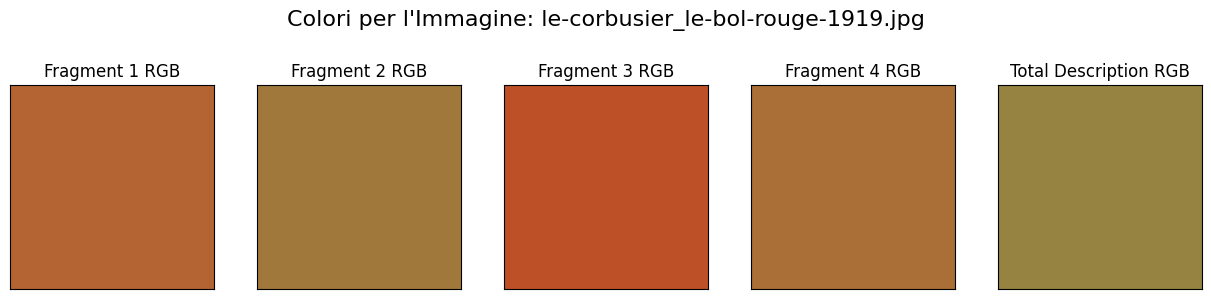

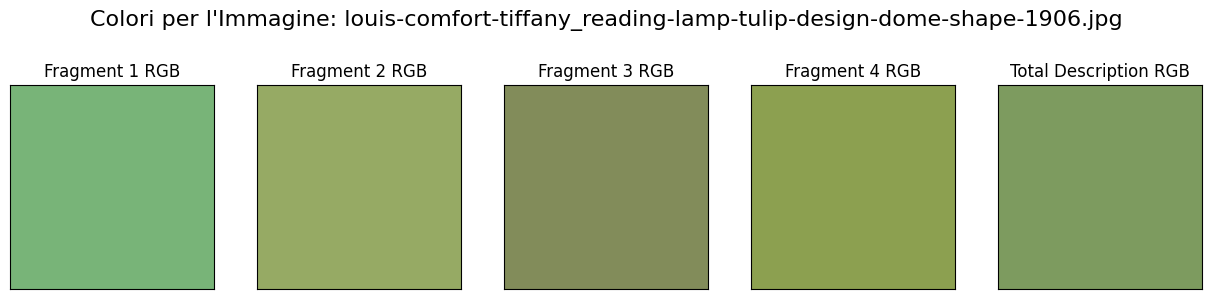

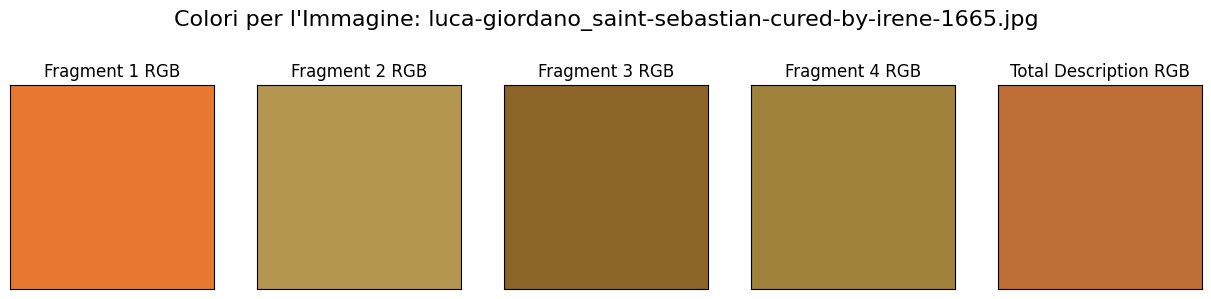

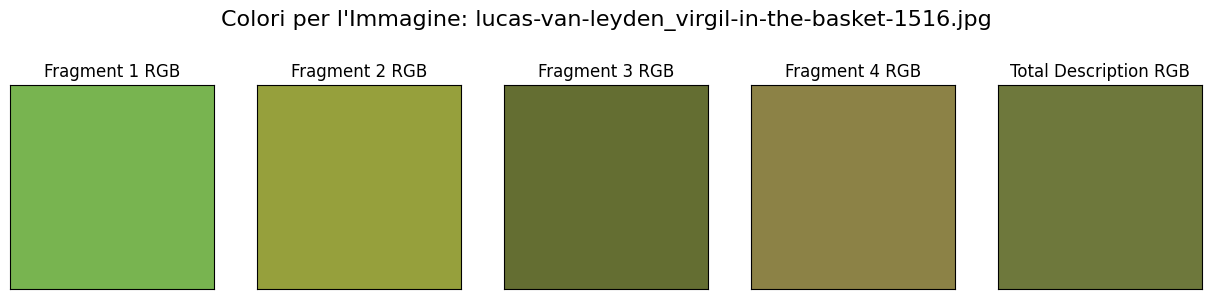

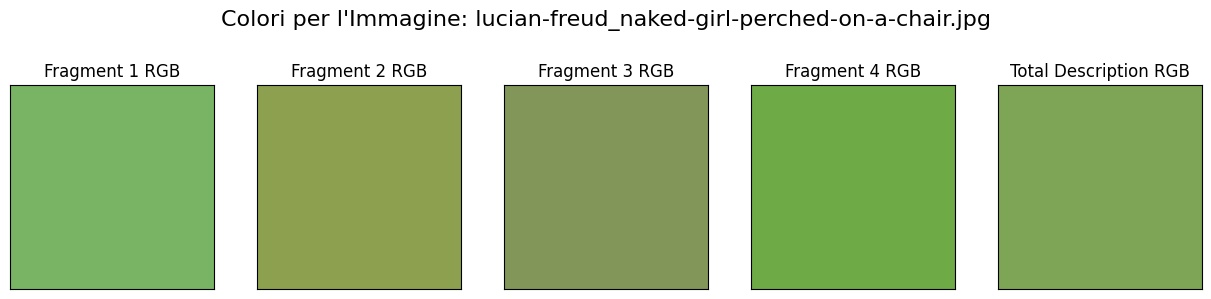

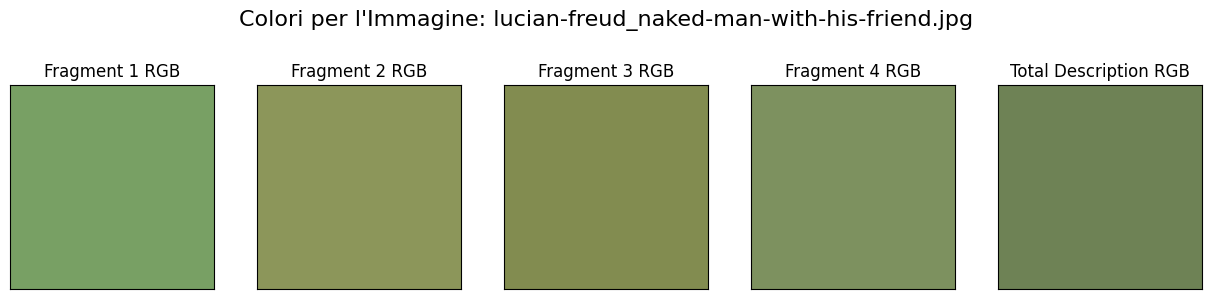

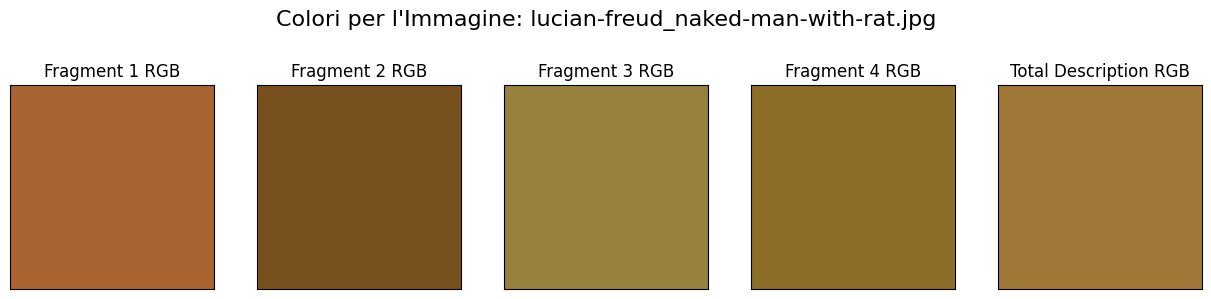

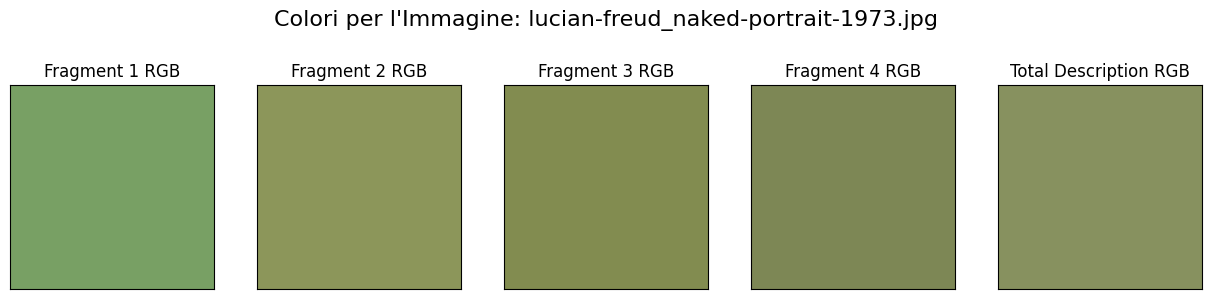

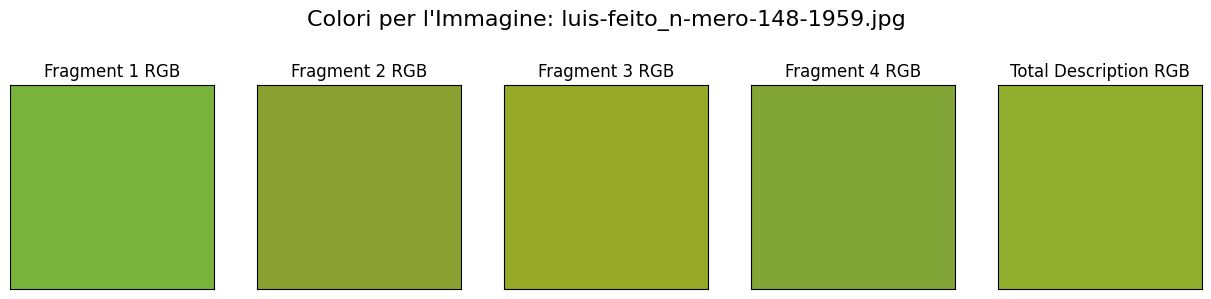

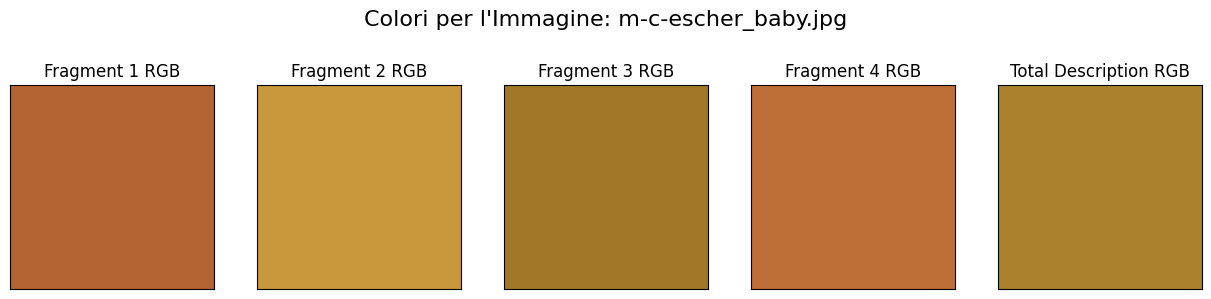

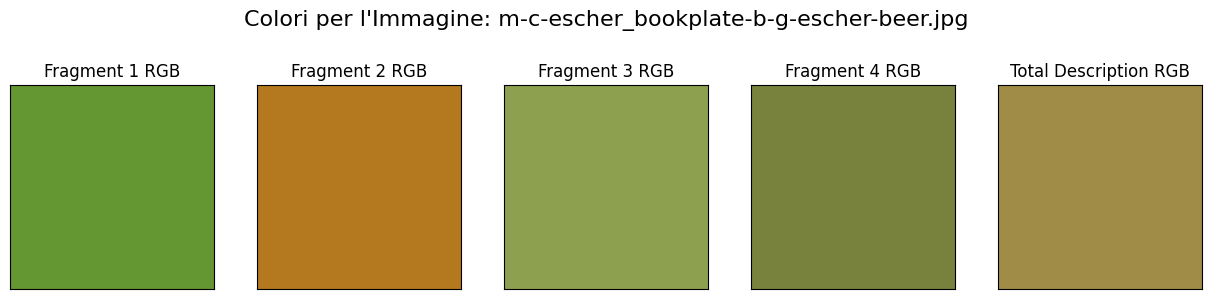

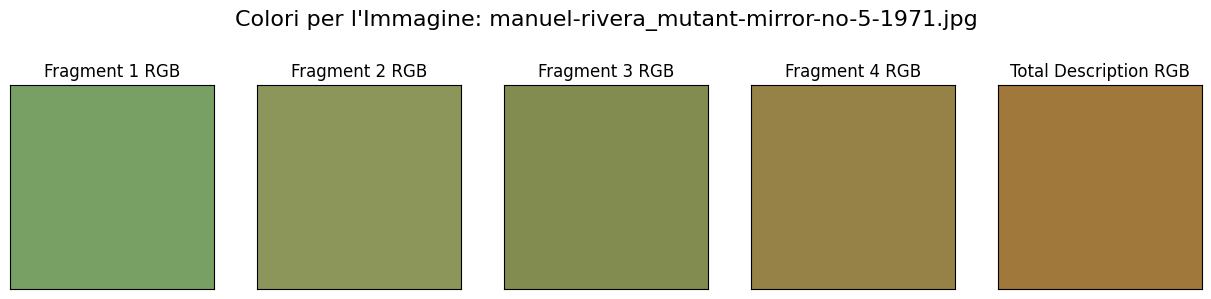

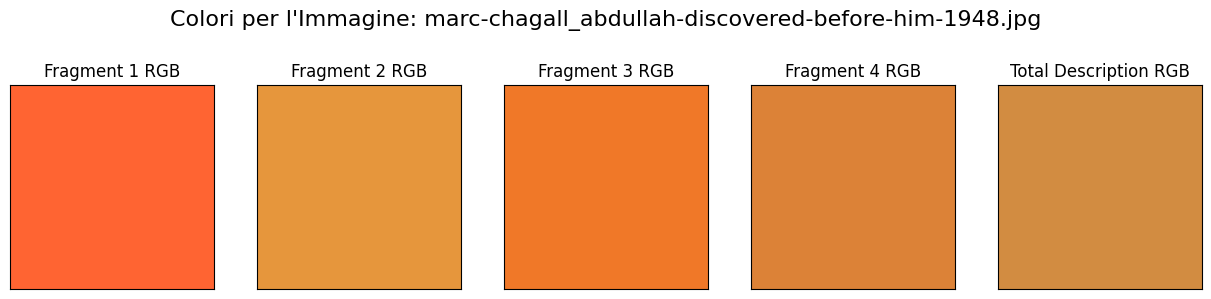

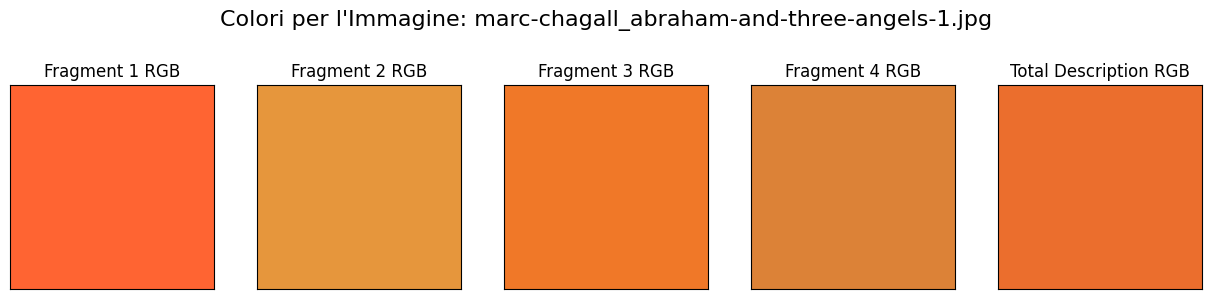

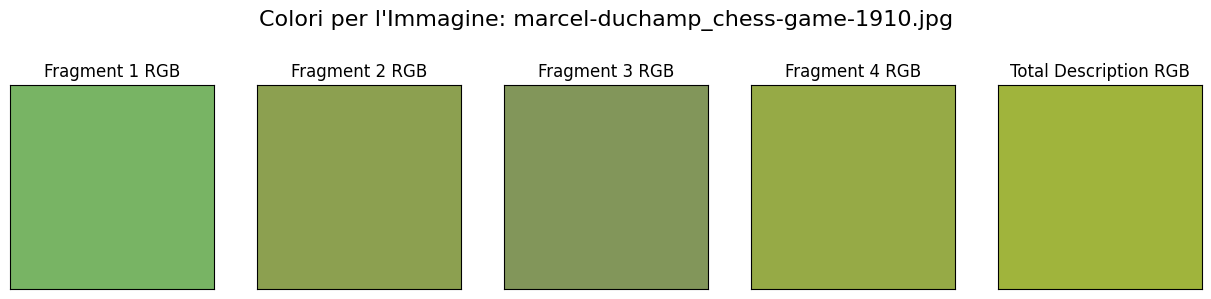

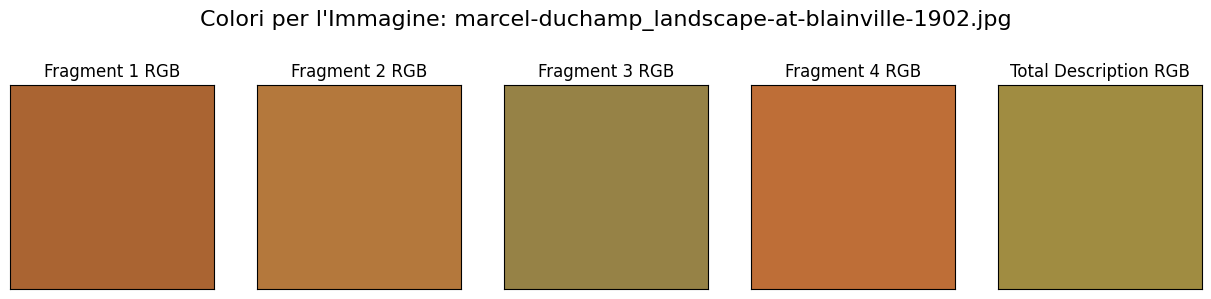

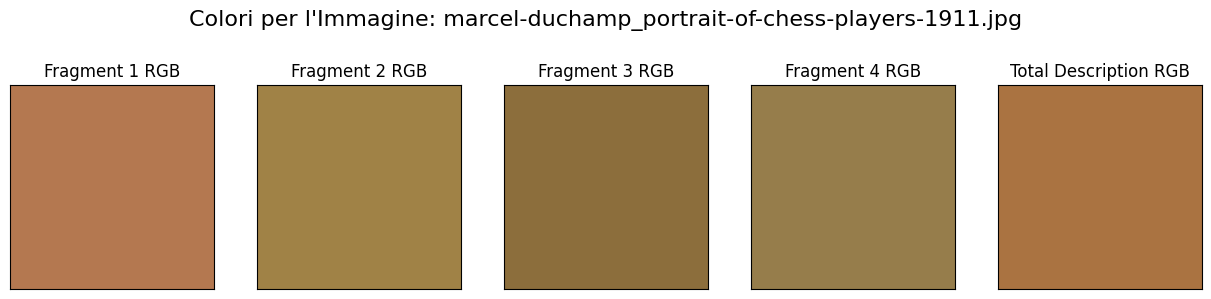

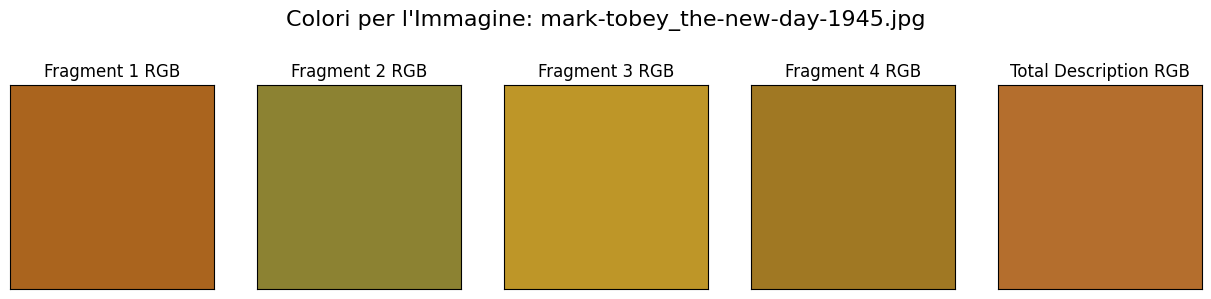

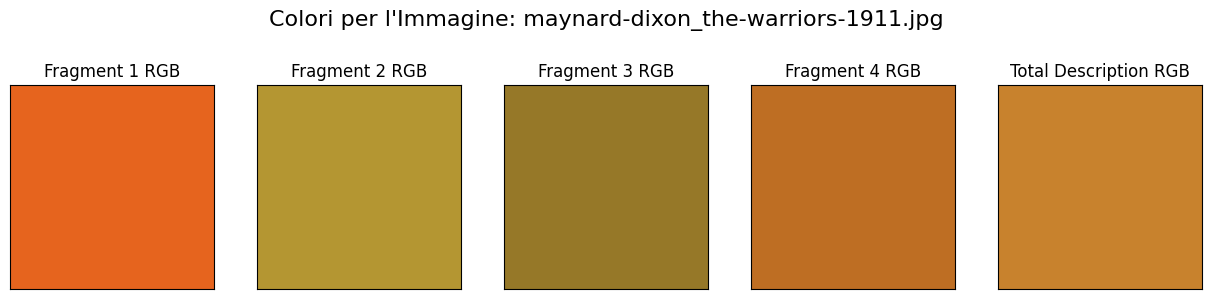

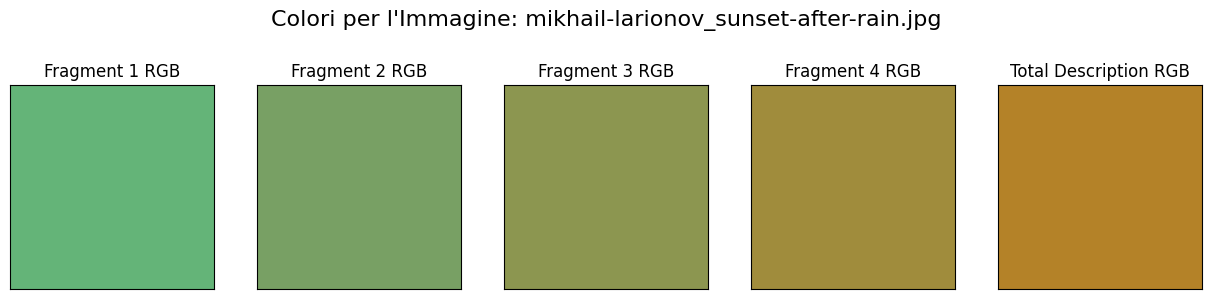

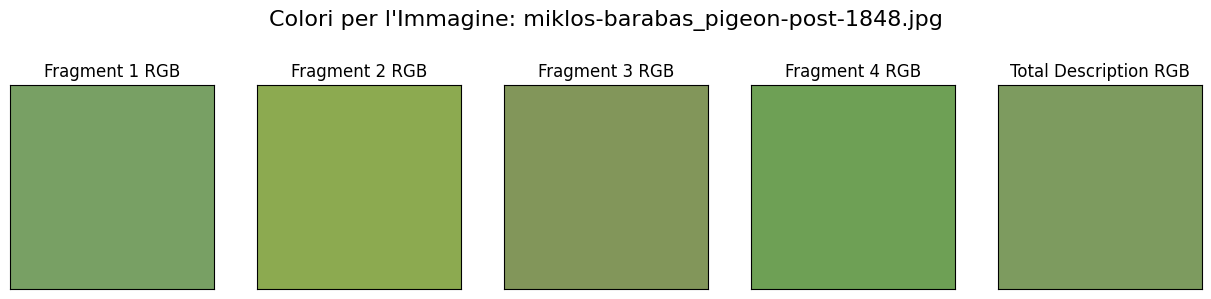

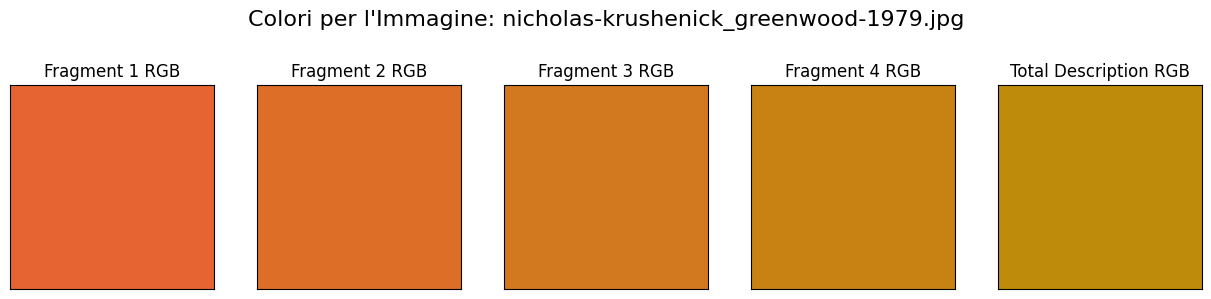

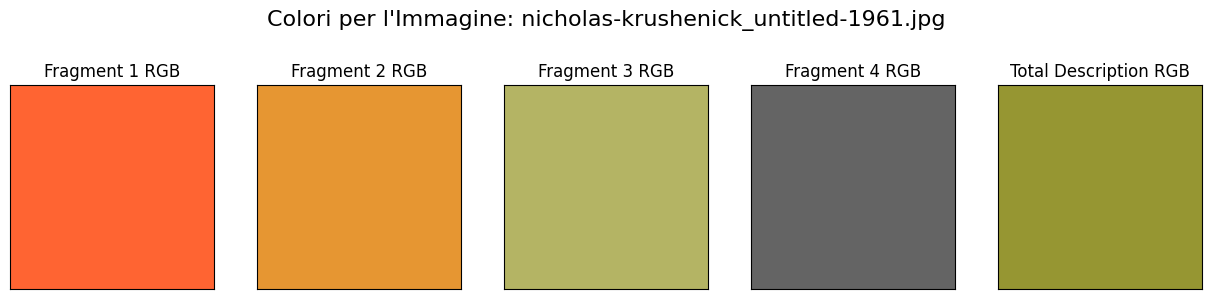

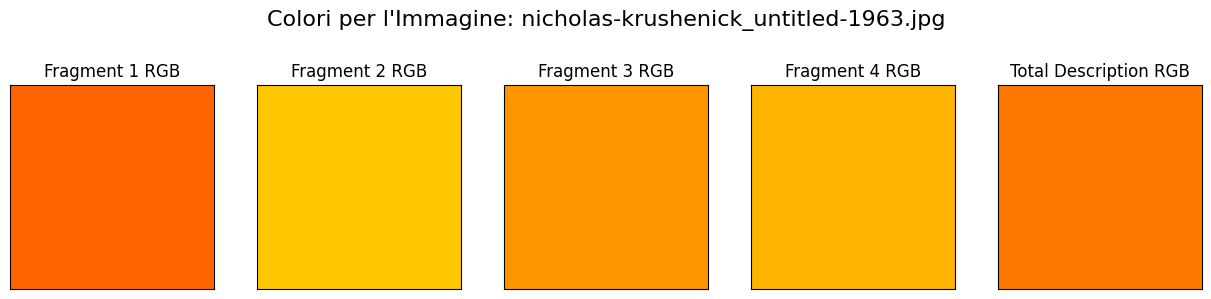

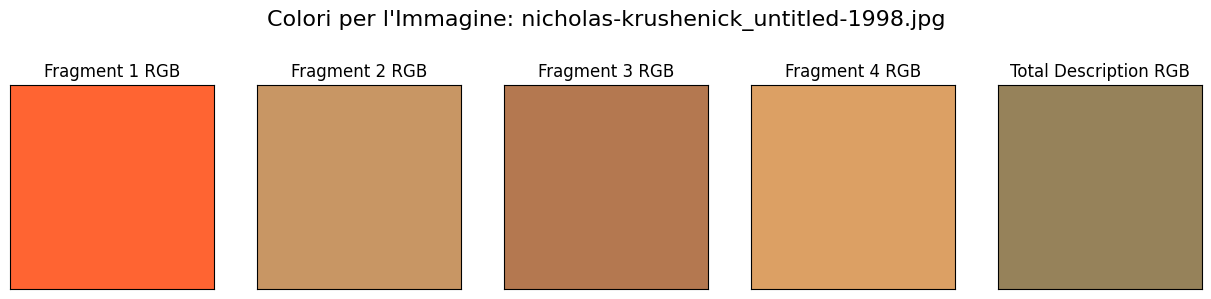

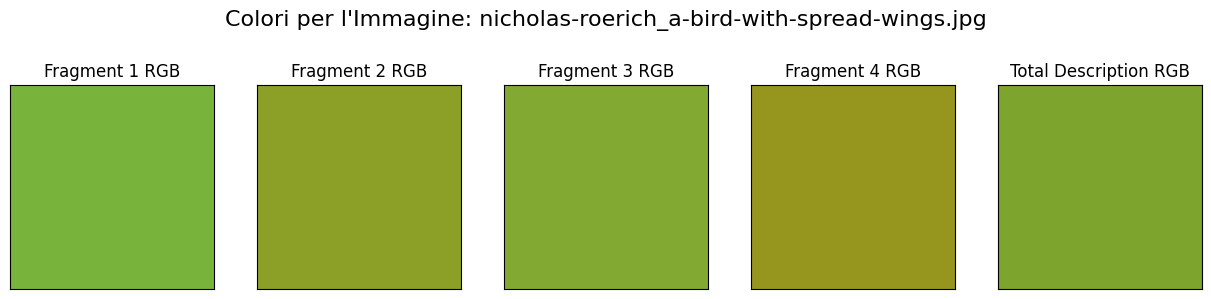

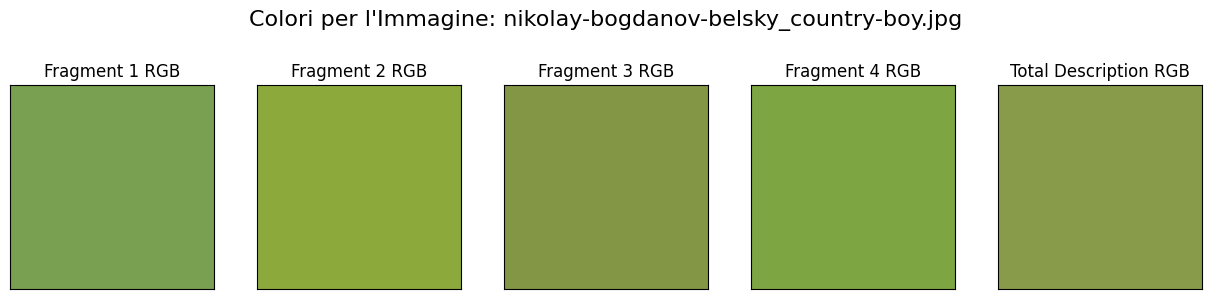

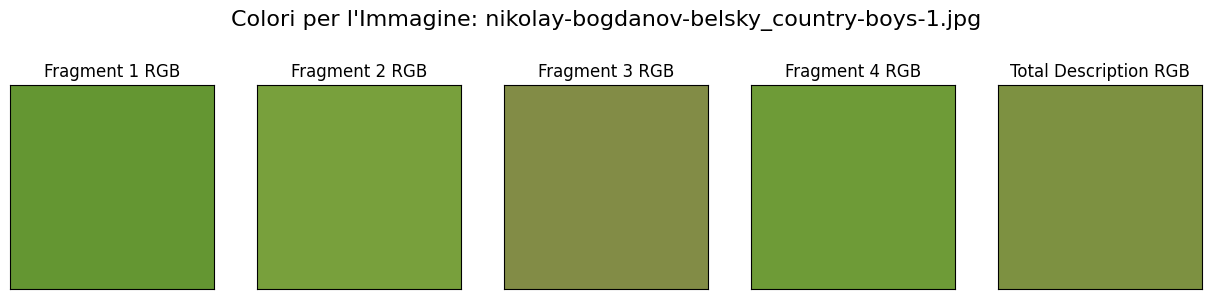

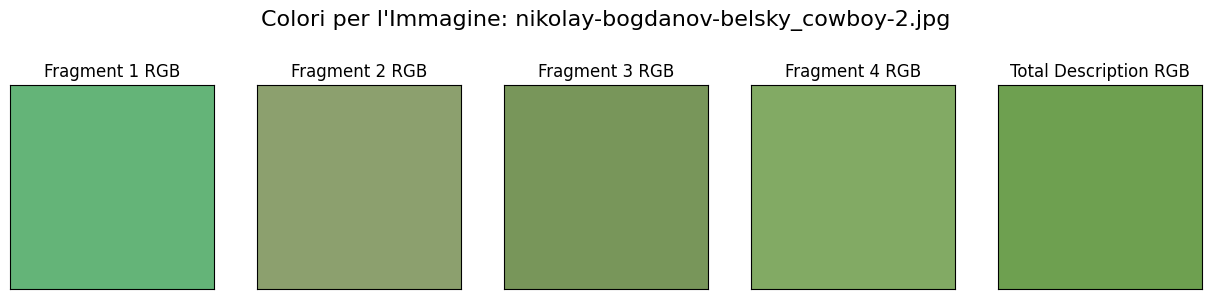

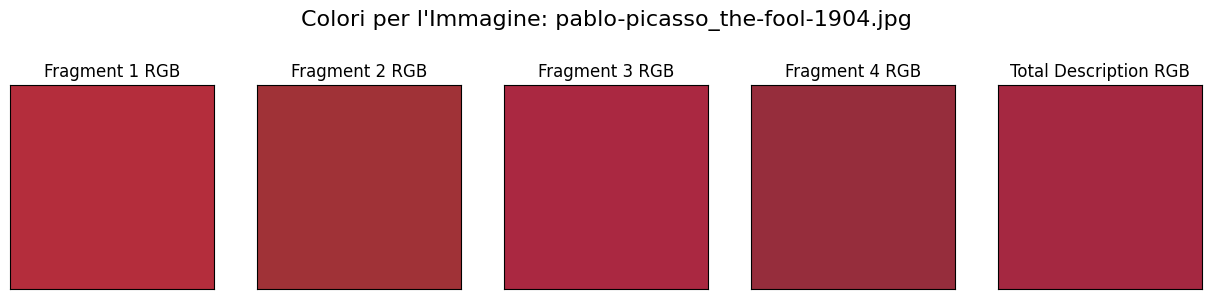

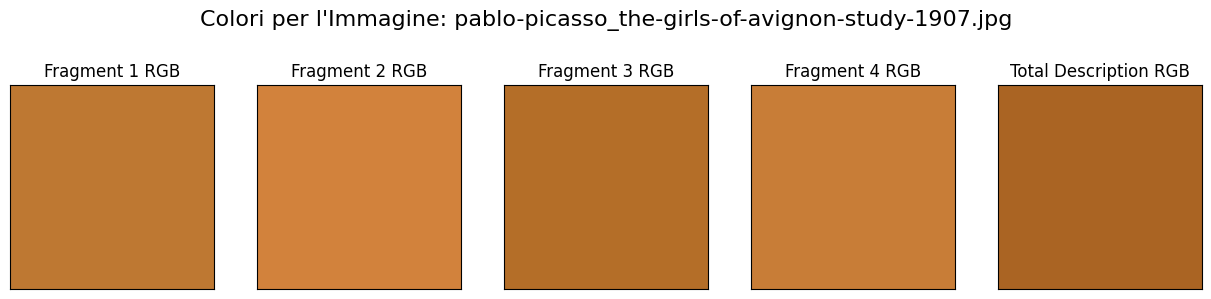

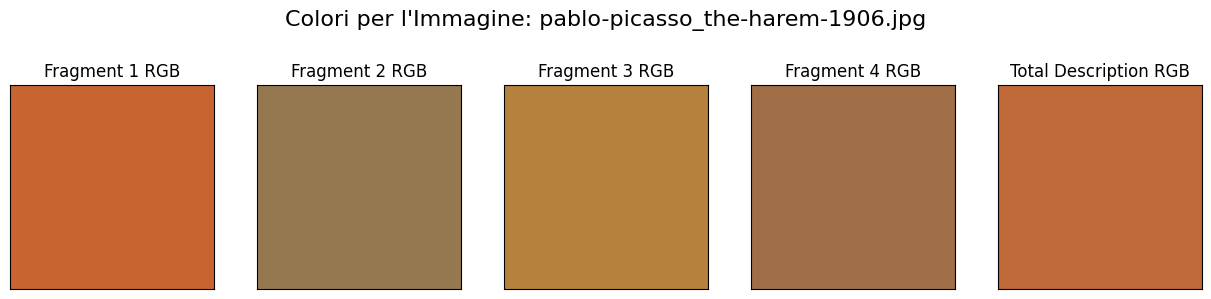

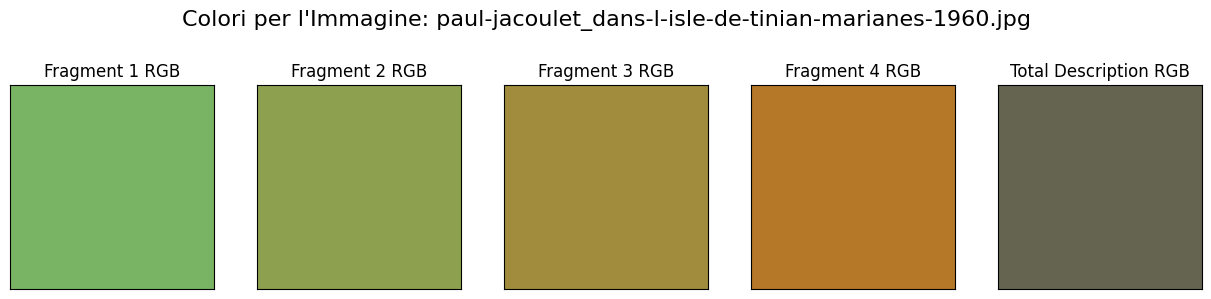

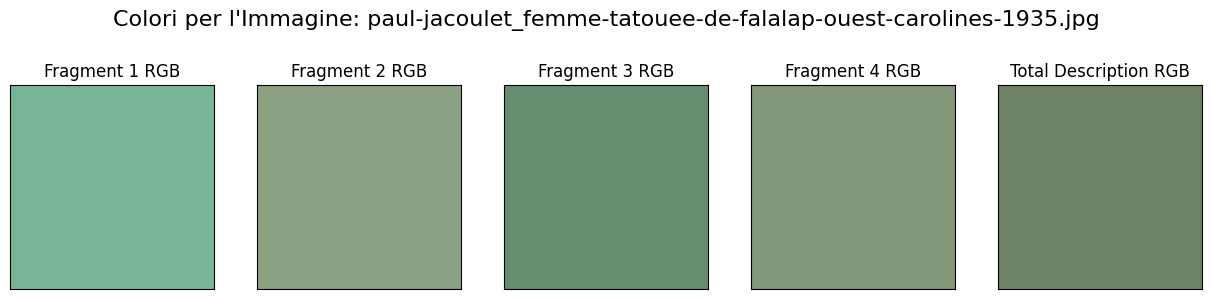

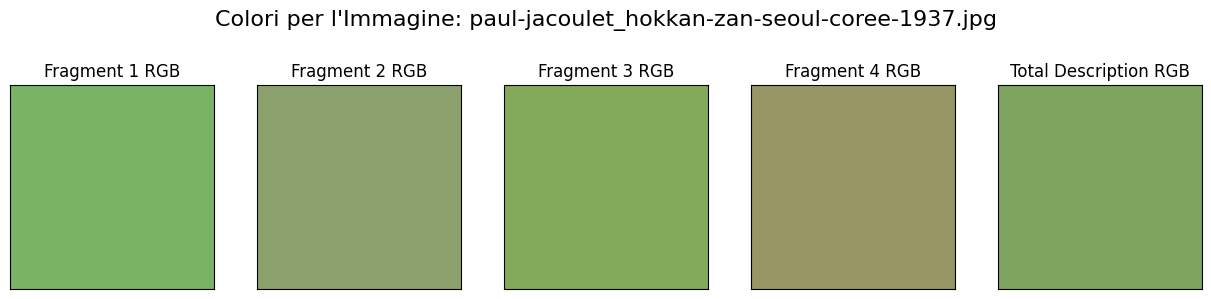

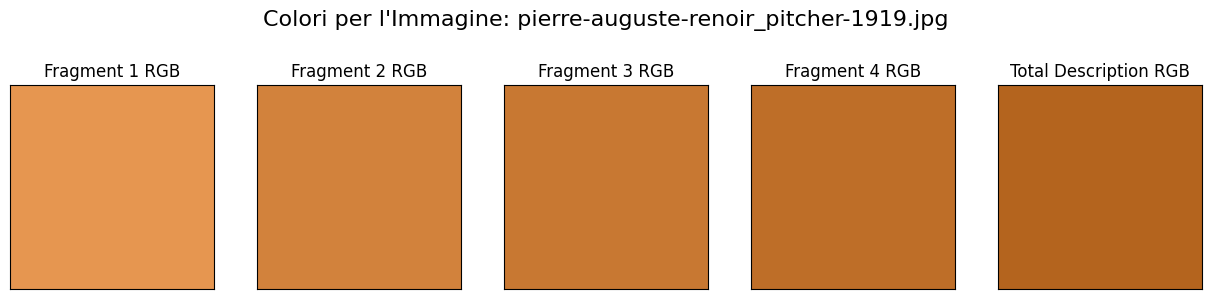

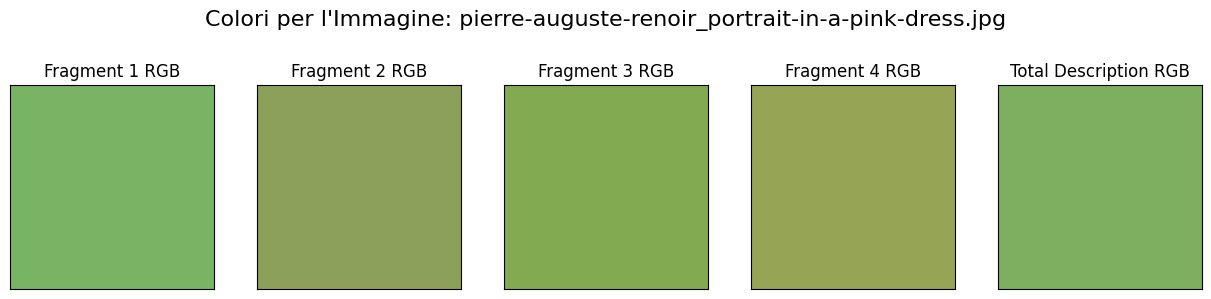

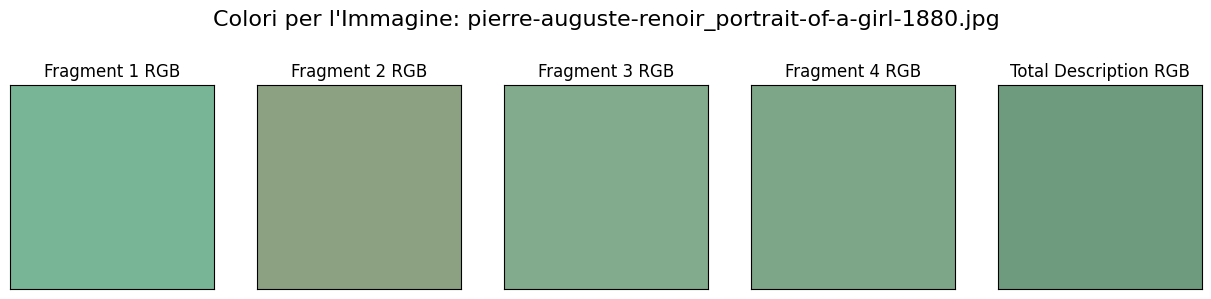

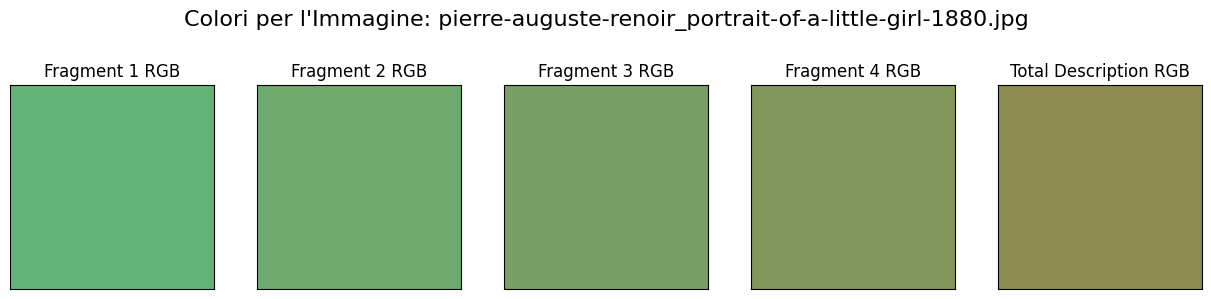

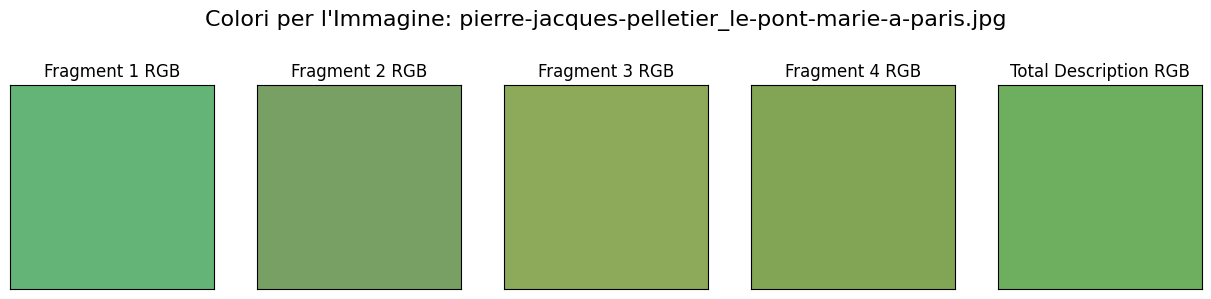

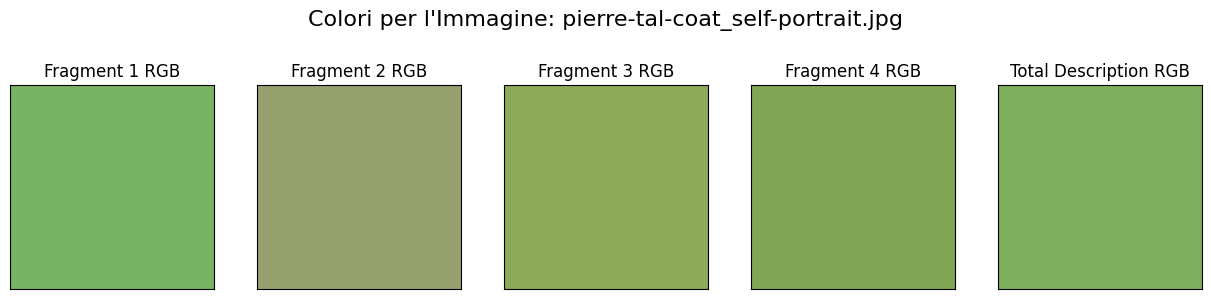

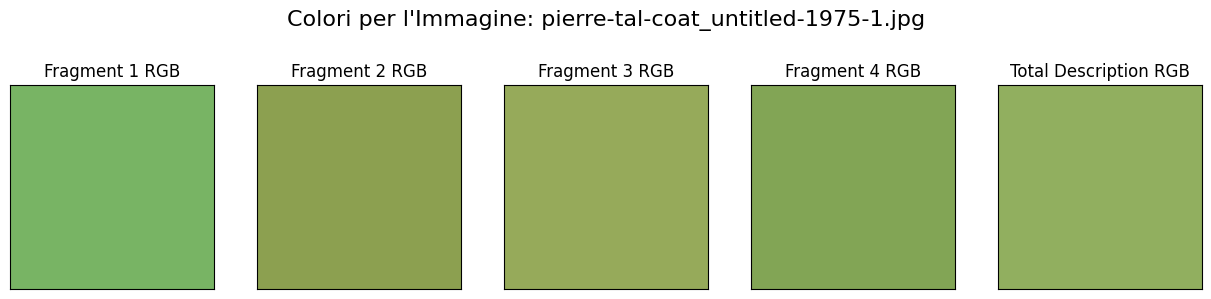

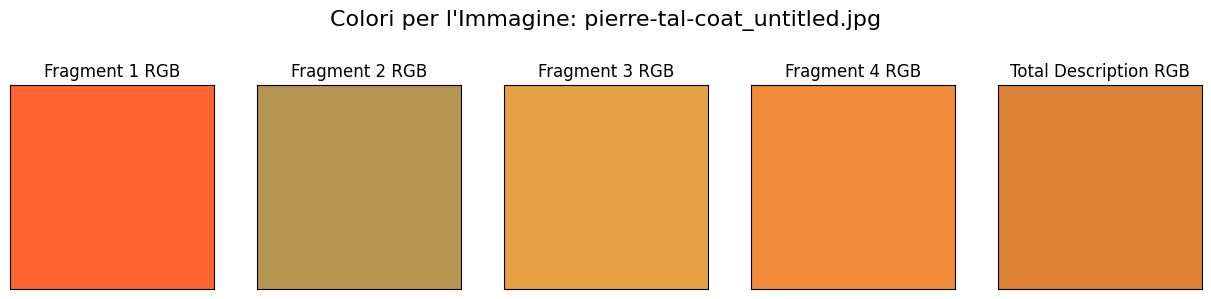

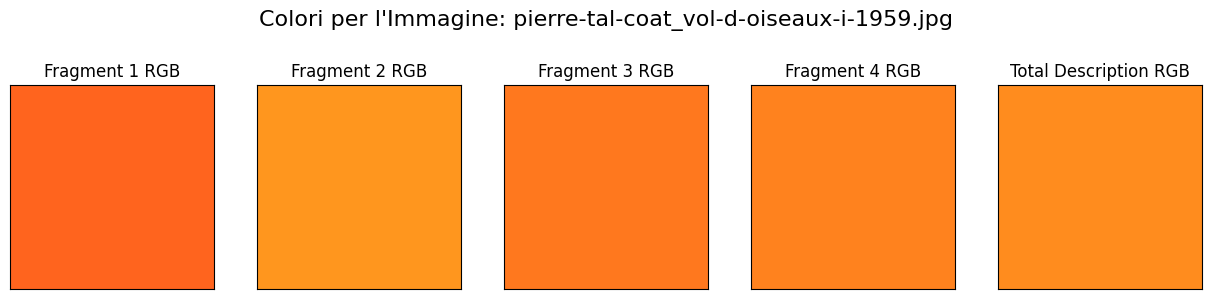

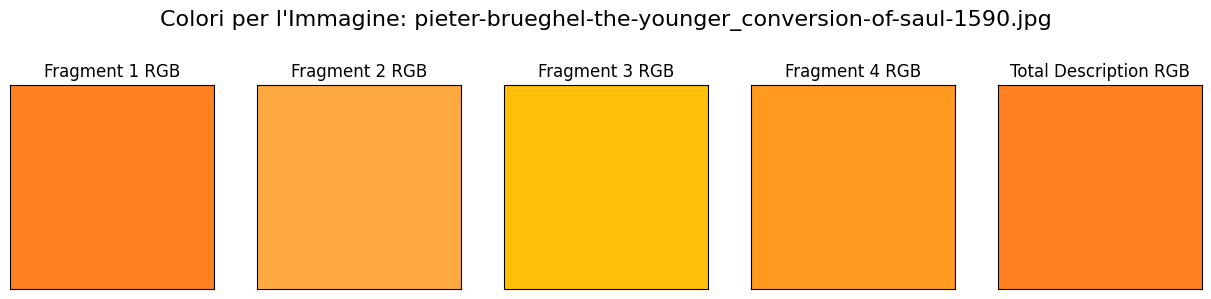

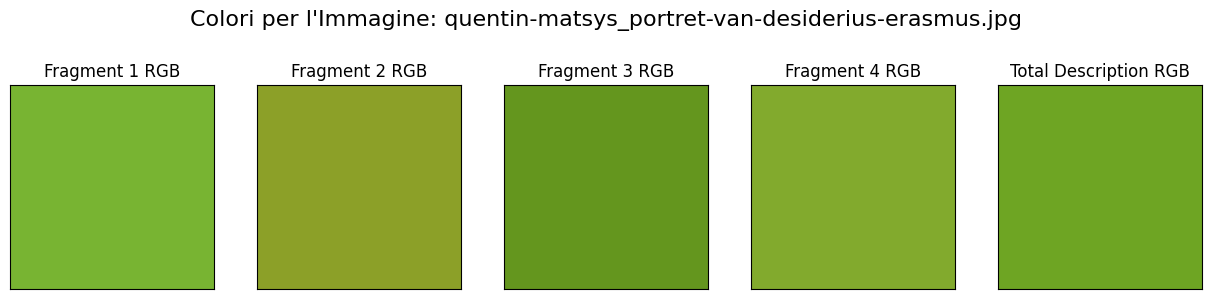

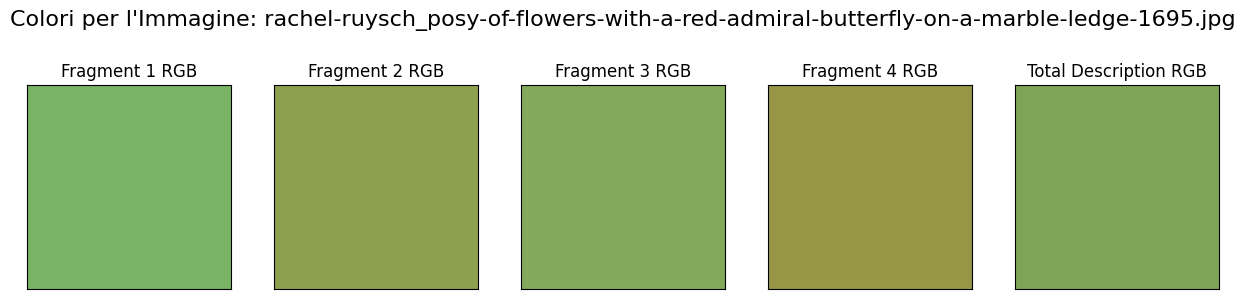

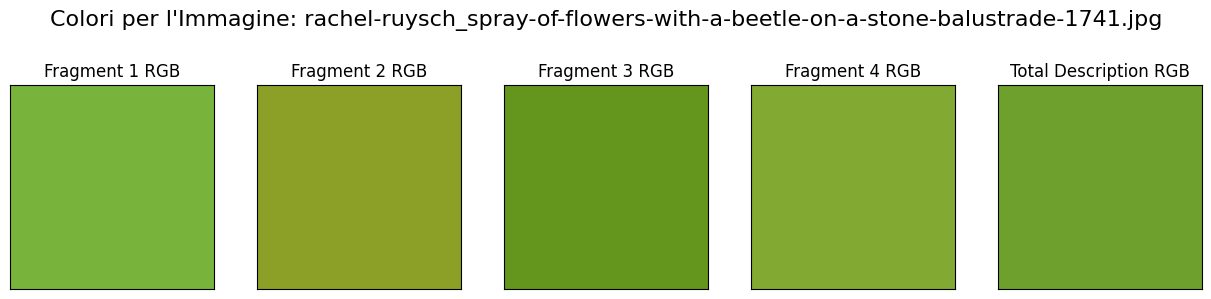

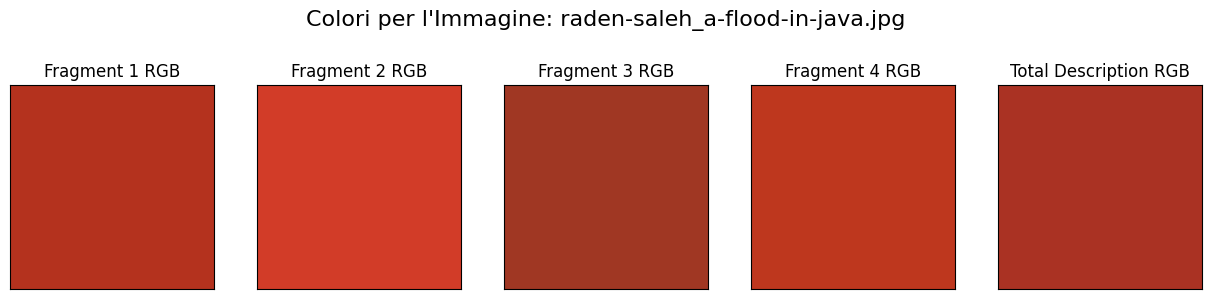

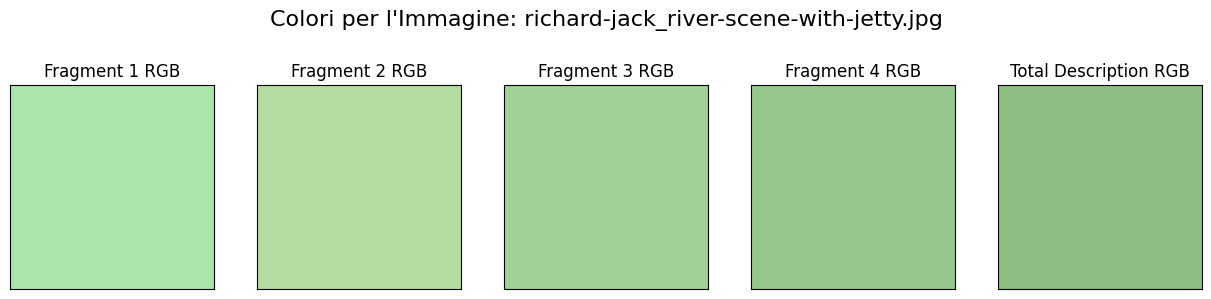

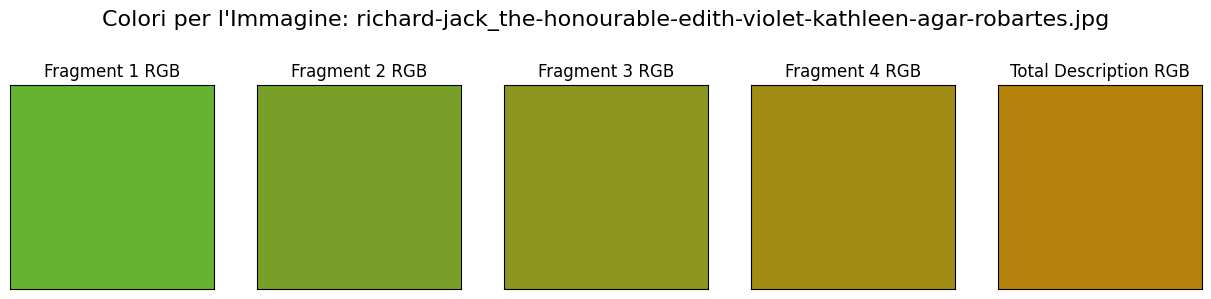

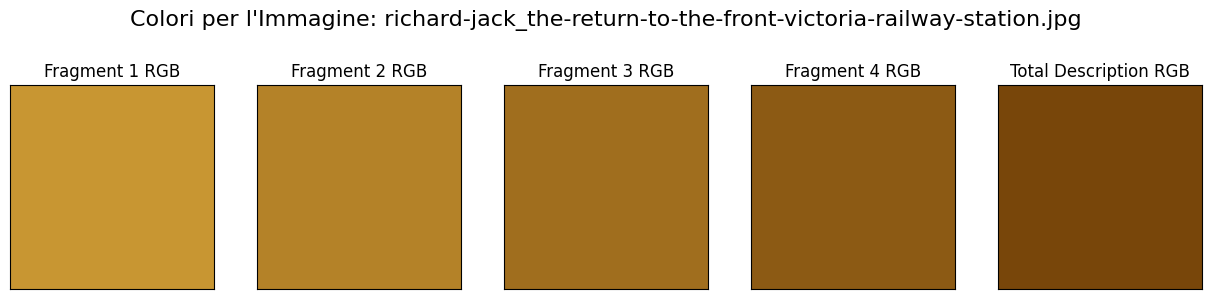

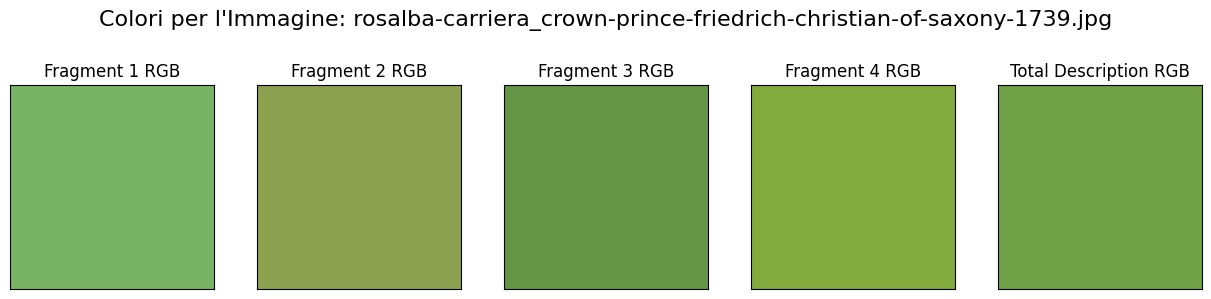

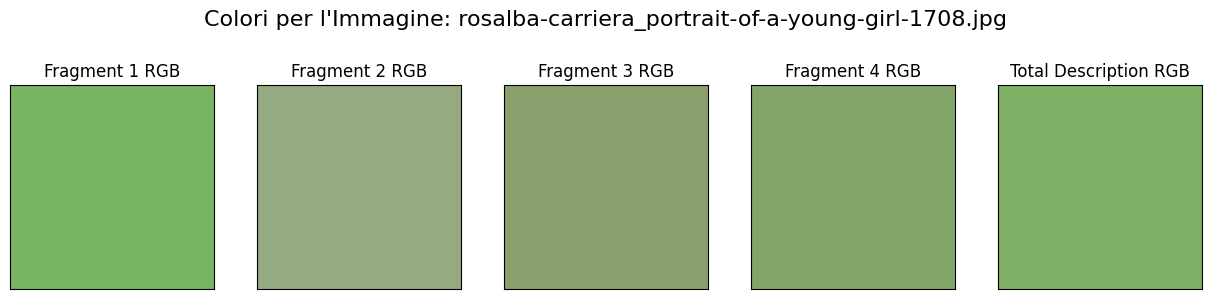

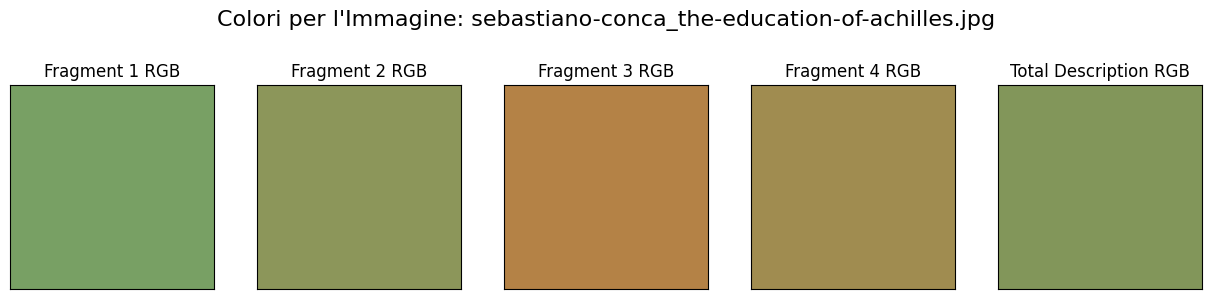

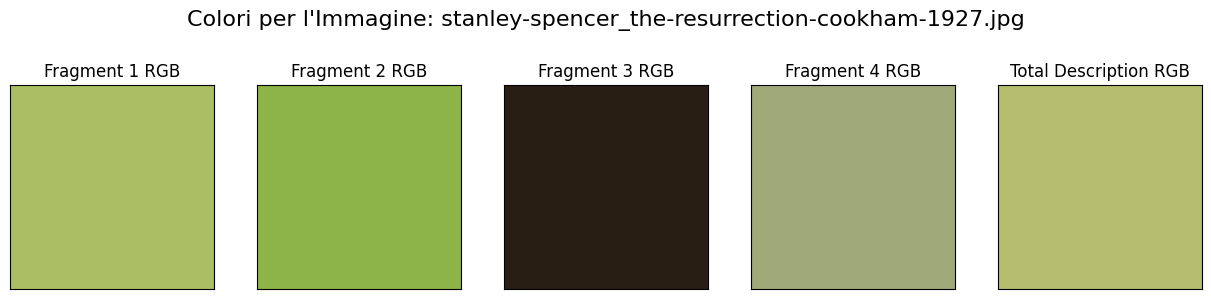

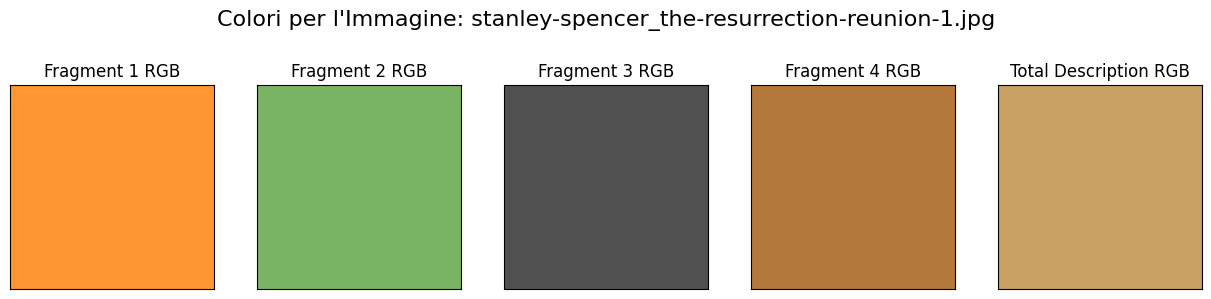

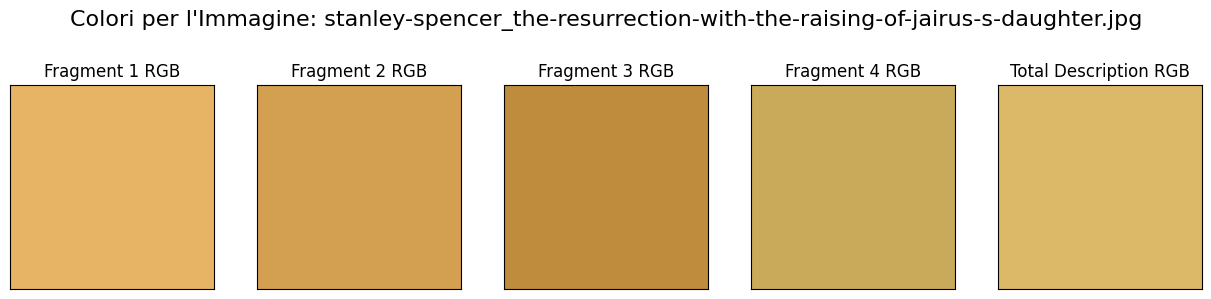

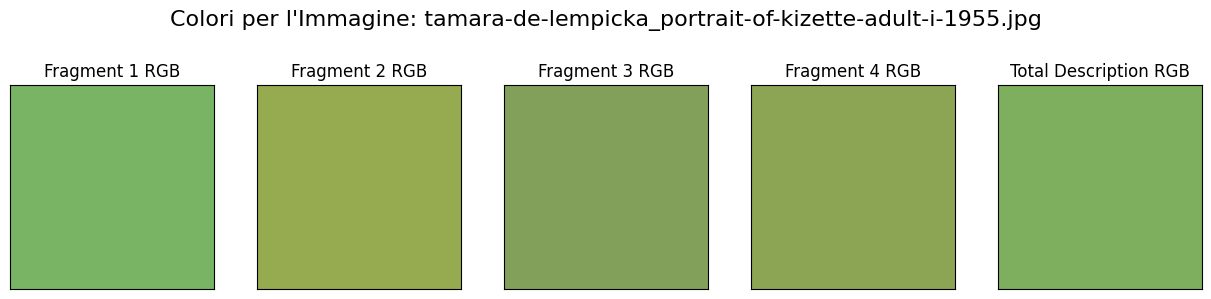

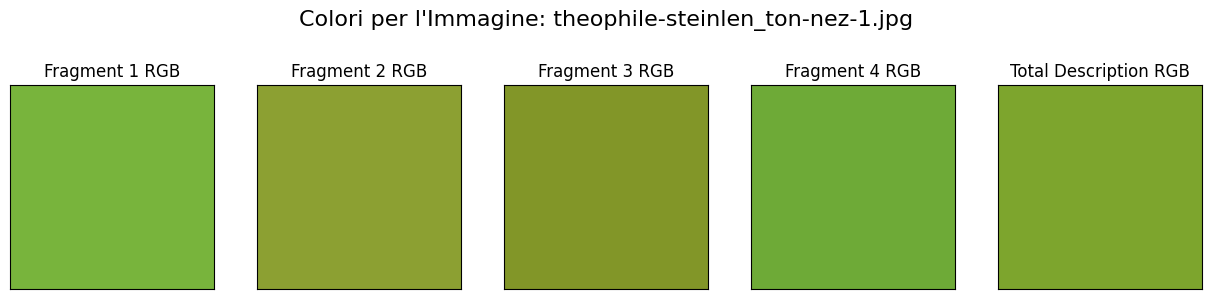

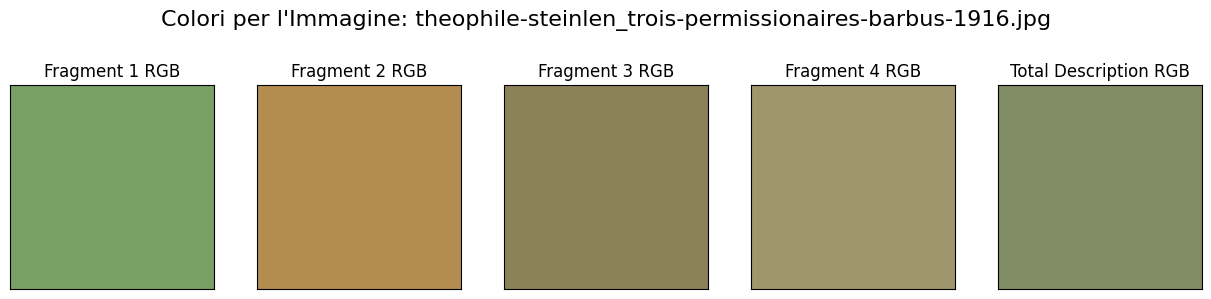

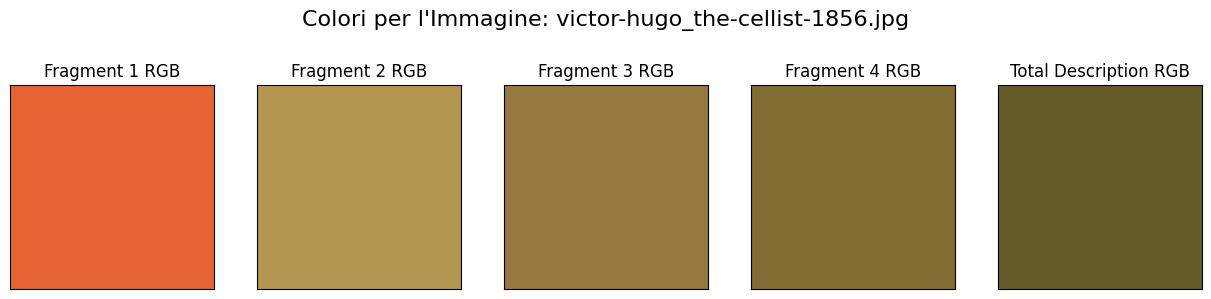

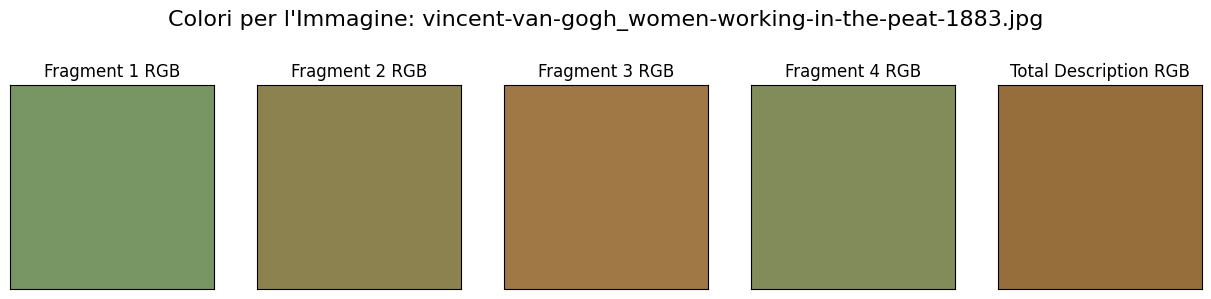

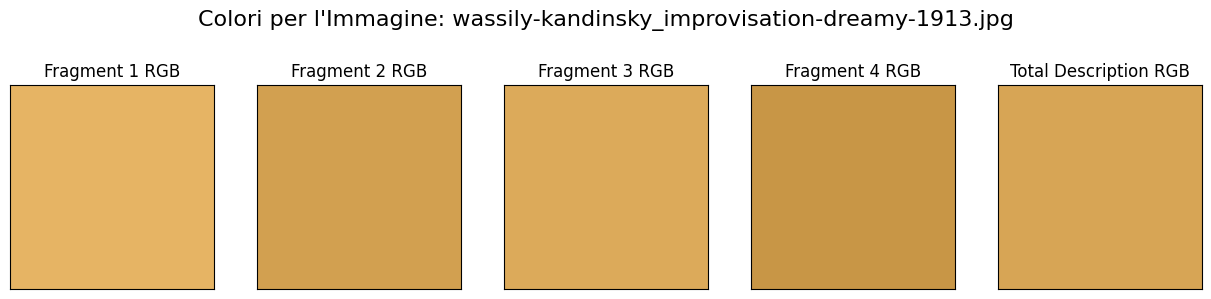

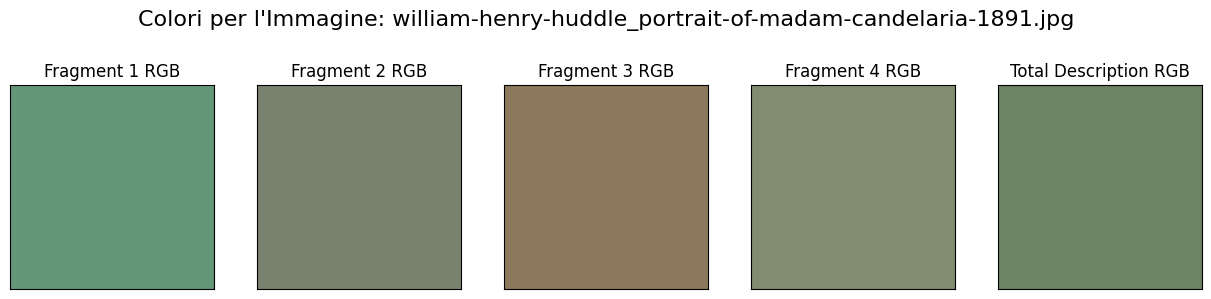

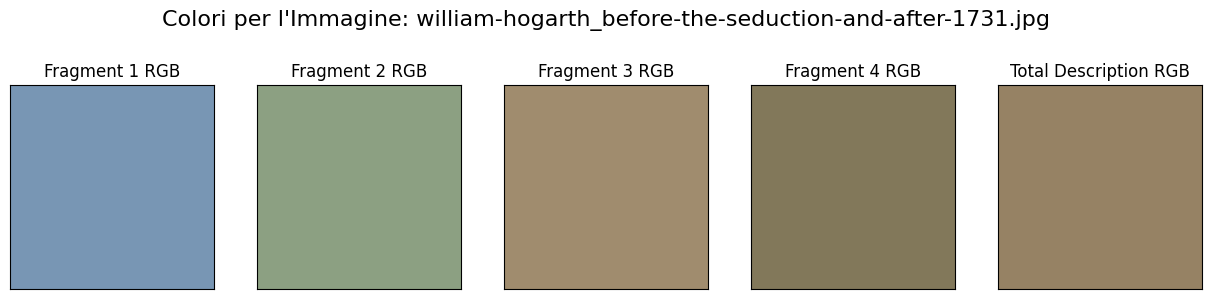

In [8]:
# --- ESECUZIONE DELLA VISUALIZZAZIONE ---
file_da_leggere_visualizzazione = output_csv_file # Usa il nome del file CSV appena salvato
visualizza_colori_immagini(file_da_leggere_visualizzazione, max_immagini=100) # Puoi cambiare max_immagini